## This is a notebook to reproduce main figures for the ELEP paper
Written by Congcong Yuan, 2023-07

Contents:
1. INSTANCE case
2. PNW case


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygmt

### Figures for INSTANCE case
Note: the length of all traces are cut down to 60s from 120s; the startting time is randomly reset between 1s and 4s; the whole dataset is portionaly categorized into 15 groups according to their signal-to-noise ratios. 

#### load prediction results from all pretrained models

In [3]:
# load data from original prediction
folder_list = ['snr_-2_2', 'snr_2_4', 'snr_4_6', 'snr_6_8', 'snr_8_10', 'snr_10_12', 'snr_12_14', 'snr_14_16', 'snr_16_18', \
    'snr_18_20', 'snr_20_25', 'snr_25_30', 'snr_30_35', 'snr_35_40', 'snr_40_100']
# model_name_list = ["eqt_original","eqt_ethz","eqt_instance","eqt_scedc","eqt_stead", "eqt_lendb","eqt_neic"]
model_name_list = ["eqt_original","eqt_ethz","eqt_instance","eqt_scedc","eqt_stead", "eqt_neic"] # "eqt_lendb" is not well trained
dirpath = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/INSTANCE_prediction_02/original/summary_csv/'
dirpath_mbf = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/INSTANCE_prediction_02/mbf_optimal/summary_csv/'
prefix = 'Instance_events_counts_4pick_filt_'

# initializing
nfolders, nmodels = len(folder_list), len(model_name_list)
dt, nt = 0.01, 6000
ntraces = 15000 # per group
ntrace_list = np.zeros([nmodels,nfolders], dtype=int)
detect_stats_list = np.zeros([nmodels, nfolders], dtype=int) # count of detections 
p_pick_stats_list = np.zeros([nmodels, nfolders, 6]) # 0: count, 1: average; 2: standard deviation; 3: MAE; 4: RMSE; 5: outlier rate
s_pick_stats_list = np.zeros([nmodels, nfolders, 6]) # 0: count, 1: average; 2: standard deviation; 3: MAE; 4: RMSE; 5: outlier rate

detect_stats_mbf_list = np.zeros([nmodels, nfolders], dtype=int) 
p_pick_stats_mbf_list = np.zeros([nmodels, nfolders, 6]) 
s_pick_stats_mbf_list = np.zeros([nmodels, nfolders, 6])

misfit_p_target_list, misfit_s_target_list = [], []
misfit_p_target_mbf_list, misfit_s_target_mbf_list = [], []
mdl_target = "eqt_instance"

# start reading
for ifd, fd in enumerate(folder_list[:]):
    for imdl, mdlnm in enumerate(model_name_list[:]):
        # print(f'working on ifd, imdl={ifd}, {imdl}')
        flnm = prefix + fd + '_testing_pred_' + mdlnm
        # load original predictions
        csv_signal = pd.read_csv(dirpath+flnm+'.csv')
        trace_nam_list = csv_signal['trace_name'].values
        p_arrival_sample_list = csv_signal['p_arrival_sample'].values
        s_arrival_sample_list = csv_signal['s_arrival_sample'].values
        pred_d_arrival_time_list = csv_signal['pred_d_arrival_time'].values # wrong header name in csv
        pred_p_arrival_time_list = csv_signal['pred_p_arrival_time'].values # should be time not sample
        pred_s_arrival_time_list = csv_signal['pred_s_arrival_time'].values
        
        ntrace_list[imdl, ifd] = len(trace_nam_list)
        
        # load mbf predictions
        csv_signal_mbf = pd.read_csv(dirpath_mbf+flnm+'.csv')
        trace_nam_mbf_list = csv_signal_mbf['trace_name'].values
        p_arrival_sample_mbf_list = csv_signal_mbf['p_arrival_sample'].values
        s_arrival_sample_mbf_list = csv_signal_mbf['s_arrival_sample'].values
        pred_d_arrival_time_mbf_list = csv_signal_mbf['pred_d_arrival_time'].values
        pred_p_arrival_time_mbf_list = csv_signal_mbf['pred_p_arrival_time'].values
        pred_s_arrival_time_mbf_list = csv_signal_mbf['pred_s_arrival_time'].values
        
        # inspection and analysis
        d_count = 0
        misfit_p_list, misfit_s_list = [], []
        for itr in range(ntraces):
            # P picks
            true_p = int(p_arrival_sample_list[itr])*dt
            pred_p = pred_p_arrival_time_list[itr] 
            if ~np.isnan(pred_p):
                pred_p = float(pred_p)
                misfit_p_list.append(pred_p-true_p)
            # S picks
            true_s = int(s_arrival_sample_list[itr])*dt
            pred_s = pred_s_arrival_time_list[itr] 
            if ~np.isnan(pred_s):
                pred_s = float(pred_s)
                misfit_s_list.append(pred_s-true_s)
            # detection
            pred_d = pred_d_arrival_time_list[itr] 
            if type(pred_d)==str:
                d_count += 1
                # [d0, d1] = ast.literal_eval(pred_d)
                # if (true_s*dt >= d0) and (true_s*dt<=d1):
                #     d_count += 1
        # append misfits
        if mdlnm == mdl_target:
            misfit_p_target_list.append(misfit_p_list)
            misfit_s_target_list.append(misfit_s_list)
            
        # inspection and analysis for mbf
        d_count_mbf = 0
        misfit_p_mbf_list, misfit_s_mbf_list = [], []
        for itr in range(ntraces):
            # P picks
            true_p = int(p_arrival_sample_mbf_list[itr])*dt
            pred_p = pred_p_arrival_time_mbf_list[itr] 
            if ~np.isnan(pred_p):
                pred_p = float(pred_p)
                misfit_p_mbf_list.append(pred_p-true_p)
            # S picks
            true_s = int(s_arrival_sample_mbf_list[itr])*dt
            pred_s = pred_s_arrival_time_mbf_list[itr] 
            if ~np.isnan(pred_s):
                pred_s = float(pred_s)
                misfit_s_mbf_list.append(pred_s-true_s)
            # detection
            pred_d = pred_d_arrival_time_mbf_list[itr] 
            if type(pred_d)==str:
                d_count_mbf += 1
        
        # append misfits
        if mdlnm == mdl_target:
            misfit_p_target_mbf_list.append(misfit_p_mbf_list)
            misfit_s_target_mbf_list.append(misfit_s_mbf_list)
            
        # statistics and write metrics
        misfit_p_list, misfit_p_mbf_list = np.array(misfit_p_list), np.array(misfit_p_mbf_list)
        misfit_s_list, misfit_s_mbf_list = np.array(misfit_s_list), np.array(misfit_s_mbf_list)
        detect_stats_list[imdl,ifd], detect_stats_mbf_list[imdl,ifd]= d_count, d_count_mbf
        
        p_pick_stats_list[imdl,ifd,0], p_pick_stats_mbf_list[imdl,ifd,0] = len(misfit_p_list), len(misfit_p_mbf_list)
        p_pick_stats_list[imdl,ifd,1], p_pick_stats_mbf_list[imdl,ifd,1] = np.mean(misfit_p_list[np.abs(misfit_p_list)<=2.0]), np.mean(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=2.0])
        p_pick_stats_list[imdl,ifd,2], p_pick_stats_mbf_list[imdl,ifd,2] = np.std(misfit_p_list[np.abs(misfit_p_list)<=10.0]), np.std(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0])
        p_pick_stats_list[imdl,ifd,3], p_pick_stats_mbf_list[imdl,ifd,3] = np.mean(np.abs(misfit_p_list[np.abs(misfit_p_list)<=10.0])), np.mean(np.abs(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0]))
        p_pick_stats_list[imdl,ifd,4], p_pick_stats_mbf_list[imdl,ifd,4] = np.sqrt(np.mean(misfit_p_list[np.abs(misfit_p_list)<=10.0]**2)), np.sqrt(np.mean(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0]**2))
        p_pick_stats_list[imdl,ifd,5], p_pick_stats_mbf_list[imdl,ifd,5] = len(misfit_p_list[np.abs(misfit_p_list)<=10.0])/len(misfit_p_list), len(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0])/len(misfit_p_mbf_list)
        
        s_pick_stats_list[imdl,ifd,0], s_pick_stats_mbf_list[imdl,ifd,0] = len(misfit_s_list), len(misfit_s_mbf_list)
        s_pick_stats_list[imdl,ifd,1], s_pick_stats_mbf_list[imdl,ifd,1] = np.mean(misfit_s_list[np.abs(misfit_s_list)<=2.0]), np.mean(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=2.0])
        s_pick_stats_list[imdl,ifd,2], s_pick_stats_mbf_list[imdl,ifd,2] = np.std(misfit_s_list[np.abs(misfit_s_list)<=10.0]), np.std(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0])
        s_pick_stats_list[imdl,ifd,3], s_pick_stats_mbf_list[imdl,ifd,3] = np.mean(np.abs(misfit_s_list[np.abs(misfit_s_list)<=10.0])), np.mean(np.abs(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0]))
        s_pick_stats_list[imdl,ifd,4], s_pick_stats_mbf_list[imdl,ifd,4] = np.sqrt(np.mean(misfit_s_list[np.abs(misfit_s_list)<=10.0]**2)), np.sqrt(np.mean(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0]**2))
        s_pick_stats_list[imdl,ifd,5], s_pick_stats_mbf_list[imdl,ifd,5] = len(misfit_s_list[np.abs(misfit_s_list)<=10.0])/len(misfit_s_list), len(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0])/len(misfit_s_mbf_list)
        

#### load in-domain prediction result from eqt-instance

In [4]:
# assemble
imdl = 2
SFB_detect_stats_hist, MFB_detect_stats_hist = [], []
SFB_detect_stats_list, MFB_detect_stats_list = [], [] # detection rate
SFB_p_stats_hist, MFB_p_stats_hist = [], []
SFB_s_stats_hist, MFB_s_stats_hist = [], []
for ifolder in range(nfolders):
    SFB_ndetects = detect_stats_list[imdl,ifolder]
    MFB_ndetects = detect_stats_mbf_list[imdl,ifolder]
    SFB_detect_stats_list.append(SFB_ndetects/ntrace_list[imdl,ifolder])
    MFB_detect_stats_list.append(MFB_ndetects/ntrace_list[imdl,ifolder])
    SFB_nppicks = int(p_pick_stats_list[imdl,ifolder,0])
    MFB_nppicks = int(p_pick_stats_mbf_list[imdl,ifolder,0])
    SFB_nspicks = int(s_pick_stats_list[imdl,ifolder,0])
    MFB_nspicks = int(s_pick_stats_mbf_list[imdl,ifolder,0])
    for id in range(SFB_ndetects):
        SFB_detect_stats_hist.append(ifolder)
    for id in range(MFB_ndetects):
        MFB_detect_stats_hist.append(ifolder)
    for id in range(SFB_nppicks):
        SFB_p_stats_hist.append(ifolder)
    for id in range(MFB_nppicks):
        MFB_p_stats_hist.append(ifolder)
    for id in range(SFB_nspicks):
        SFB_s_stats_hist.append(ifolder)
    for id in range(MFB_nspicks):
        MFB_s_stats_hist.append(ifolder)
           
SFB_p_pick_stats_list, SFB_s_pick_stats_list = np.squeeze(p_pick_stats_list[imdl]), np.squeeze(s_pick_stats_list[imdl])    
MFB_p_pick_stats_list, MFB_s_pick_stats_list = np.squeeze(p_pick_stats_mbf_list[imdl]), np.squeeze(s_pick_stats_mbf_list[imdl]) 

In [5]:
# plotting parameters 
region = [0, nfolders, 0, 25000]
region2 = [0, nfolders, -9.0, 1.]
region2p = [0, nfolders, -6.0, 2.0]
region2s = [0, nfolders, -6.0, 2.0]
region2d = [0, nfolders, 0.6, 1.1]
region3d = [0, nfolders, 0.6, 1.1]
region3p = [0, nfolders, 0.6, 1.4] # for pick rate
region3s = [0, nfolders, 0.6, 1.4]
region4p = [0, nfolders, -1.0, 1.0] # for abs error
region4s = [0, nfolders, -1.0, 1.0]
frame = ['wsne', 'x', 'y']
frame2 = ['wsnE', 'x', 'y+l"Trace counts"']
series = 1
series2 = 1
styles = ["c", "d", "h", "i", "s", "t"]
cfill = ["gray", "gray", "black", "black"]
cfill2 = ["black", "black", "black", "black"]
cfill3 = ["darkorange1", "blue", "seagreen", "red4"]
pen = "1p"
histtype = 0
transparency=50

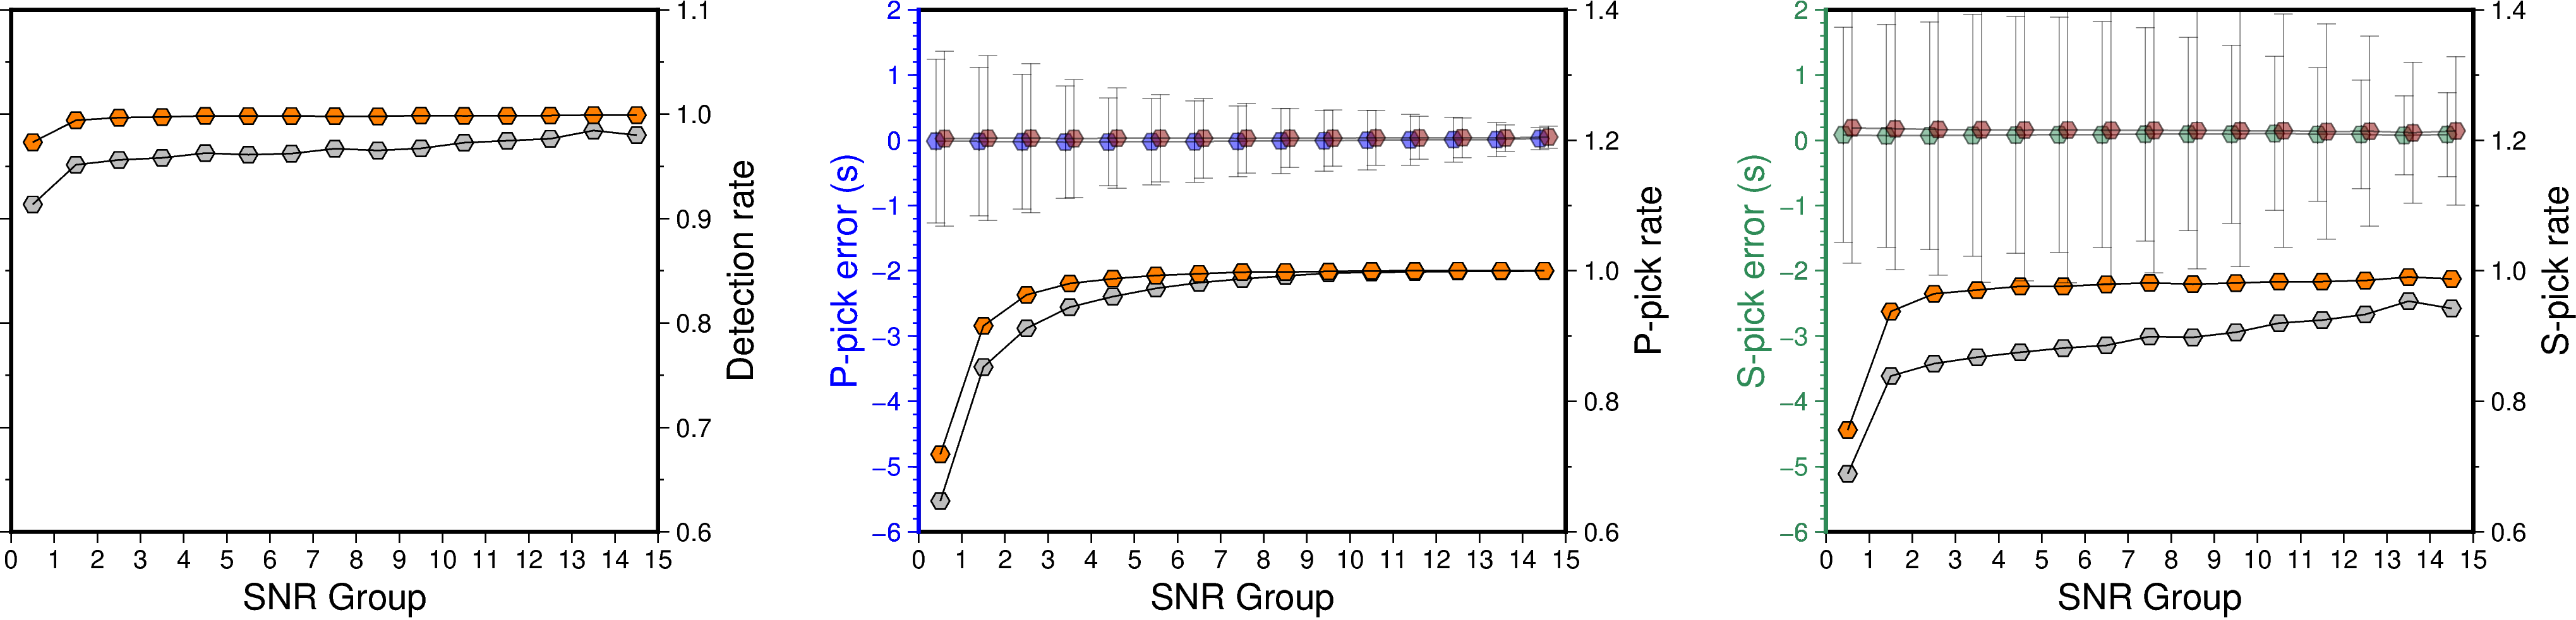

In [6]:
# combine BB and MB results
# plot picking rate instead of count (MBF)
fig = pygmt.Figure()
# Bottom row, two subplots
with fig.subplot(nrows=1, ncols=3, figsize=("33c", "7c"), autolabel=None, margins=["1.5c", "0c"]):
    fig.basemap(
        region=region3d, projection="X?", frame=["S", 'xa1f1+l"SNR Group"'], panel=[0, 0]
    )
    with fig.set_panel(panel=[0, 0]):
        # ===== Plot for detection =======
        # plot for left axis
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(frame=["w", 'ya0.1f0.05+l"Count of detections"'])  
        
        
            # # plot markers
            # fig.plot(
            #     data=df.to_numpy(),
            #     style=styles[imdl]+"0.25c",
            #     pen="0.5p,black",
            #     color=cfill[0],
            #     error_bar = False,
            #     transparency = transparency,
            #     # label = mdlnm
            # )
            # # plot line
            # fig.plot(
            #     x=x,
            #     y=y,
            #     pen="0.5p,black",
            #     transparency = transparency
            # )
        
        # plot for the right axis
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
           fig.basemap(region=region3d, frame=["nE", 'ya0.1f0.05+l"Detection rate"']) 
        
        # for imdl, mdlnm in enumerate(model_name_list):
        imdl = 2 # eqt_scedc
        SFB_detect_stats_list = []
        for ifolder in range(nfolders): 
            SFB_ndetects = detect_stats_list[imdl,ifolder]
            SFB_detect_stats_list.append(SFB_ndetects/ntrace_list[imdl, ifolder])
        x, y = np.arange(0.5, nfolders+0.5), SFB_detect_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill[0],
            error_bar = False,
            # transparency = transparency,
            # label = mdlnm
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            # transparency=transparency
        )
        # multiband results   
        MFB_detect_stats_list = []
        for ifolder in range(nfolders): 
            MFB_ndetects = detect_stats_mbf_list[imdl,ifolder]
            MFB_detect_stats_list.append(MFB_ndetects/ntrace_list[imdl, ifolder])
        x, y = np.arange(0.5, nfolders+0.5), MFB_detect_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill3[0],
            error_bar = False,
            # transparency = transparency,
            # label = mdlnm
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            # transparency=transparency
        )
        
    # fig.legend(position="jBR+o0.2c", box=True)         
    # ======= Plot for P picks ========
    fig.basemap(region=region2p, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 1]
    )
    with fig.set_panel(panel=[0, 1]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3p, frame=['E', 'yaf+l"P-pick rate"'])  
        
        # for imdl, mdlnm in enumerate(model_name_list):
        imdl = 2 # eqt_scedc
        
        SFB_p_stats_list = []
        for ifolder in range(nfolders): 
            SFB_nppicks = int(p_pick_stats_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
            SFB_p_stats_list.append(SFB_nppicks)
        x, y = np.arange(0.5, nfolders+0.5), SFB_p_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill[0],
            error_bar = False,
            # transparency = transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            # transparency = transparency
        )
        
        # multiband results
        MFB_p_stats_list = []
        for ifolder in range(nfolders): 
            MFB_nppicks = int(p_pick_stats_mbf_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
            MFB_p_stats_list.append(MFB_nppicks)
        x, y = np.arange(0.5, nfolders+0.5), MFB_p_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill3[0],
            error_bar = False,
            # transparency = transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            # transparency = transparency
        )
        
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN=cfill3[1],
            MAP_TICK_PEN=cfill3[1],
            FONT_ANNOT_PRIMARY=cfill3[1],
            FONT_LABEL=cfill3[1],
        ):
           fig.basemap(region=region2p, frame=["W", 'ya1f0.2+l"P-pick error (s)"']) 
        
        # for imdl, mdlnm in enumerate(model_name_list):    
        imdl = 2 # eqt_scedc 
        SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list[imdl]) 
        x, y = np.arange(0.4, nfolders+0.4), SFB_p_pick_stats_list[:,1]
        x_err, y_err = np.zeros([nfolders,]), SFB_p_pick_stats_list[:,2]
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill3[1],
            error_bar = True,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        # multiband results
        MFB_p_pick_stats_list = np.squeeze(p_pick_stats_mbf_list[imdl]) 
        x, y = np.arange(0.6, nfolders+0.6), MFB_p_pick_stats_list[:,1]
        x_err, y_err = np.zeros([nfolders,]), MFB_p_pick_stats_list[:,2]
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = True,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
    # ======= Plot for S picks ========
    fig.basemap(region=region2s, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 2]
    )
    with fig.set_panel(panel=[0, 2]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3s, frame=['E', 'yaf+l"S-pick rate"'])   
            
        # for imdl, mdlnm in enumerate(model_name_list):
        SFB_s_stats_list = []
        for ifolder in range(nfolders): 
            SFB_nppicks = int(s_pick_stats_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
            SFB_s_stats_list.append(SFB_nppicks)
        x, y = np.arange(0.5, nfolders+0.5), SFB_s_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill[0],
            error_bar = False,
            # transparency = transparency
        )   
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            # transparency = transparency
        )
        
        # multiband results
        MFB_s_stats_list = []
        for ifolder in range(nfolders): 
            MFB_nppicks = int(s_pick_stats_mbf_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
            MFB_s_stats_list.append(MFB_nppicks)
        x, y = np.arange(0.5, nfolders+0.5), MFB_s_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill3[0],
            error_bar = False,
            # transparency = transparency
        )   
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            # transparency = transparency
        )
            
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN=cfill3[2],
            MAP_TICK_PEN=cfill3[2],
            FONT_ANNOT_PRIMARY=cfill3[2],
            FONT_LABEL=cfill3[2],
        ):
           fig.basemap(region=region2s, frame=["W", 'ya1f0.2+l"S-pick error (s)"']) 
        # for imdl, mdlnm in enumerate(model_name_list): 
        SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list[imdl]) 
        x, y = np.arange(0.4, nfolders+0.4), SFB_s_pick_stats_list[:,1]
        x_err, y_err = np.zeros([nfolders,]), SFB_s_pick_stats_list[:,2]
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill3[2],
            error_bar = True,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        ) 
        
        # multiband results    
        MFB_s_pick_stats_list = np.squeeze(s_pick_stats_mbf_list[imdl]) 
        x, y = np.arange(0.6, nfolders+0.6), MFB_s_pick_stats_list[:,1]
        x_err, y_err = np.zeros([nfolders,]), MFB_s_pick_stats_list[:,2]
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style=styles[imdl]+"0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = True,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        ) 
fig.show()


#### plot prediction results from all pretrained models

In [7]:
region3d = [0, nfolders, 0.4, 1.1]
region3p = [0, nfolders, 0.4, 1.6] # for pick rate
region3s = [0, nfolders, 0.4, 1.6]
region4p = [0, nfolders, -3, 3.0]
region4s = [0, nfolders, -3, 3]

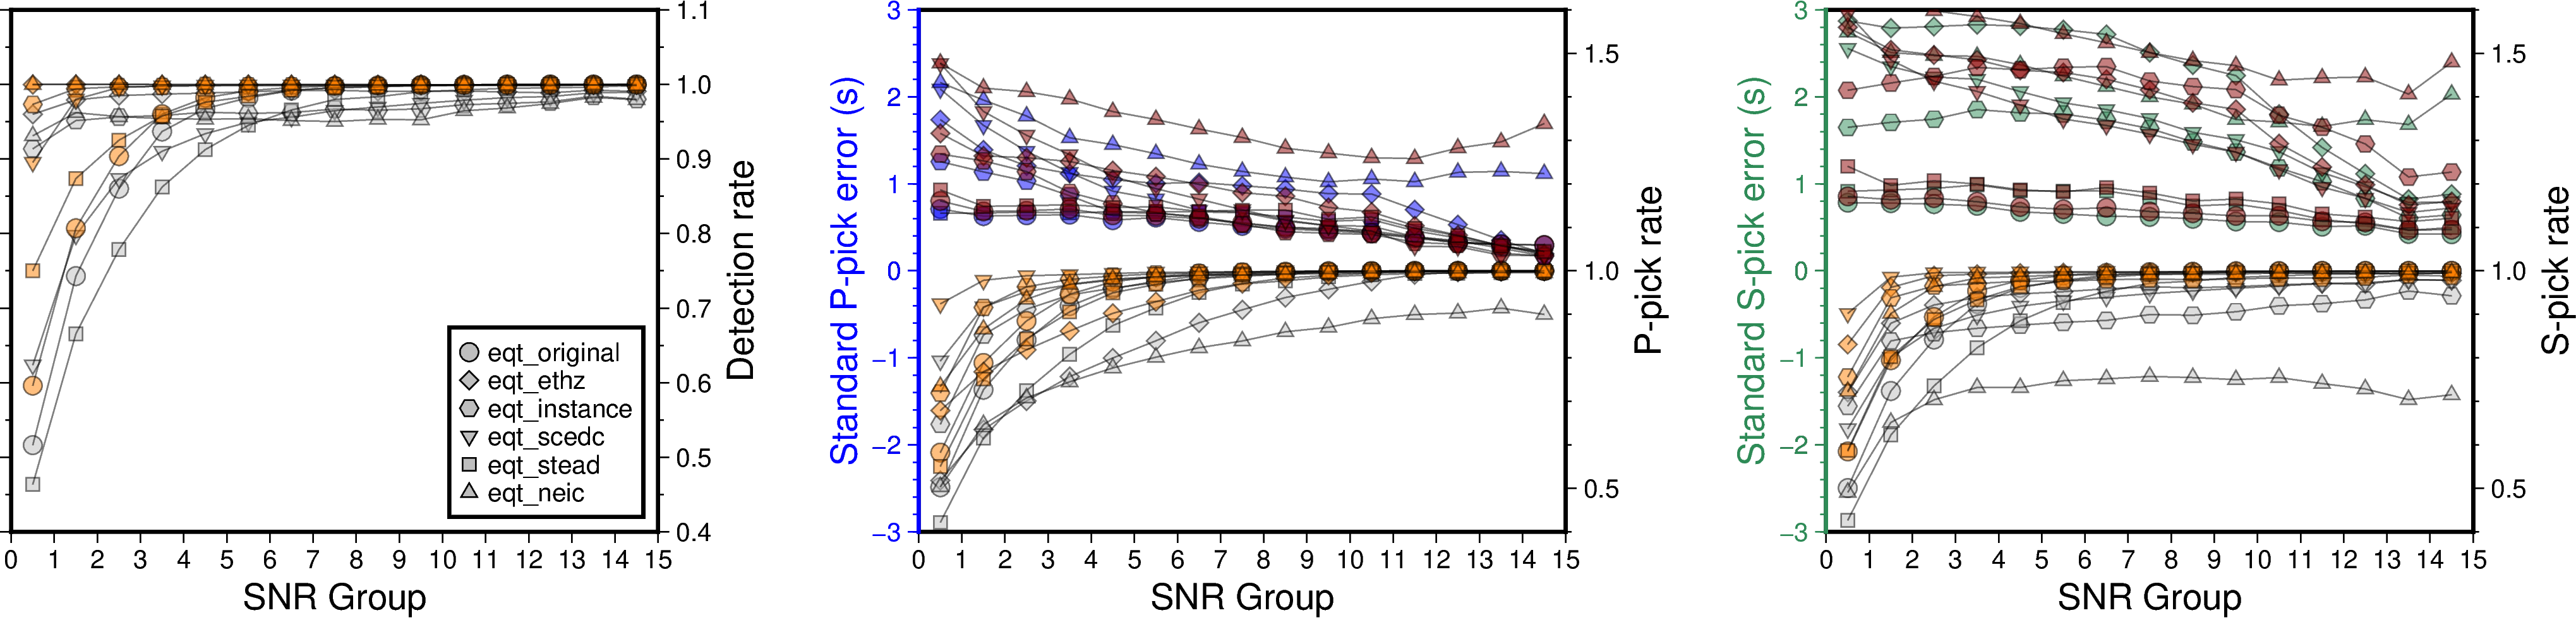

In [8]:
# plot picking rate instead of count (BB&MBF)
fig = pygmt.Figure()
# Bottom row, two subplots
with fig.subplot(nrows=1, ncols=3, figsize=("33c", "7c"), autolabel=None, margins=["1.5c", "0c"]):
    fig.basemap(
        region=region3d, projection="X?", frame=["S", 'xa1f1+l"SNR Group"'], panel=[0, 0]
    )
    with fig.set_panel(panel=[0, 0]):
        # ===== Plot for detection =======
        # plot for left axis
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(frame=["nw", 'ya0.1f0.05+l"Count of detections"'])  
        
        
            # # plot markers
            # fig.plot(
            #     data=df.to_numpy(),
            #     style=styles[imdl]+"0.25c",
            #     pen="0.5p,black",
            #     color=cfill[0],
            #     error_bar = False,
            #     transparency = transparency,
            #     # label = mdlnm
            # )
            # # plot line
            # fig.plot(
            #     x=x,
            #     y=y,
            #     pen="0.5p,black",
            #     transparency = transparency
            # )
        
        # plot for the right axis
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
           fig.basemap(region=region3d, frame=["E", 'ya0.1f0.05+l"Detection rate"']) 
        
        for imdl, mdlnm in enumerate(model_name_list):
            SFB_detect_stats_list = []
            for ifolder in range(nfolders): 
                SFB_ndetects = detect_stats_list[imdl,ifolder]
                SFB_detect_stats_list.append(SFB_ndetects/ntrace_list[imdl, ifolder])
            x, y = np.arange(0.5, nfolders+0.5), SFB_detect_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nfolders,]),
                "y-error": np.zeros([nfolders,]),
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill[0],
                error_bar = False,
                transparency = transparency,
                label = mdlnm
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        
        # ==== for MBF
        for imdl, mdlnm in enumerate(model_name_list):
            MFB_detect_stats_list = []
            for ifolder in range(nfolders): 
                MFB_ndetects = detect_stats_mbf_list[imdl,ifolder]
                MFB_detect_stats_list.append(MFB_ndetects/ntrace_list[imdl, ifolder])
            x, y = np.arange(0.5, nfolders+0.5), MFB_detect_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nfolders,]),
                "y-error": np.zeros([nfolders,]),
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[0],
                error_bar = False,
                transparency = transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        
    fig.legend(position="jBR+o0.2c", box=True)         
    # ======= Plot for P picks ========
    fig.basemap(region=region4p, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 1]
    )
    with fig.set_panel(panel=[0, 1]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3p, frame=['E', 'yaf+l"P-pick rate"'])  
        
        for imdl, mdlnm in enumerate(model_name_list):
            SFB_p_stats_list = []
            for ifolder in range(nfolders): 
                SFB_nppicks = int(p_pick_stats_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                SFB_p_stats_list.append(SFB_nppicks)
            x, y = np.arange(0.5, nfolders+0.5), SFB_p_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nfolders,]),
                "y-error": np.zeros([nfolders,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill[0],
                error_bar = False,
                transparency = transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
        
        # ====== MBF
        for imdl, mdlnm in enumerate(model_name_list):
            MFB_p_stats_list = []
            for ifolder in range(nfolders): 
                MFB_nppicks = int(p_pick_stats_mbf_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                MFB_p_stats_list.append(MFB_nppicks)
            x, y = np.arange(0.5, nfolders+0.5), MFB_p_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nfolders,]),
                "y-error": np.zeros([nfolders,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[0],
                error_bar = False,
                transparency = transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
        
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN=cfill3[1],
            MAP_TICK_PEN=cfill3[1],
            FONT_ANNOT_PRIMARY=cfill3[1],
            FONT_LABEL=cfill3[1],
        ):
           fig.basemap(region=region4p, frame=["W", 'ya1.0f0.2+l"Standard P-pick error (s)"']) 
        
        for imdl, mdlnm in enumerate(model_name_list):     
            SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list[imdl]) 
            x, y = np.arange(0.5, nfolders+0.5), SFB_p_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[1],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        # ====== MBF
        for imdl, mdlnm in enumerate(model_name_list):     
            MFB_p_pick_stats_list = np.squeeze(p_pick_stats_mbf_list[imdl]) 
            x, y = np.arange(0.5, nfolders+0.5), MFB_p_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[3],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        
    # ======= Plot for S picks ========
    fig.basemap(region=region4s, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 2]
    )
    with fig.set_panel(panel=[0, 2]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3s, frame=['E', 'yaf+l"S-pick rate"'])   
            
        for imdl, mdlnm in enumerate(model_name_list):
            SFB_s_stats_list = []
            for ifolder in range(nfolders): 
                SFB_nppicks = int(s_pick_stats_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                SFB_s_stats_list.append(SFB_nppicks)
            x, y = np.arange(0.5, nfolders+0.5), SFB_s_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nfolders,]),
                "y-error": np.zeros([nfolders,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill[0],
                error_bar = False,
                transparency = transparency
            )   
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
        
        # ======== MBF
        for imdl, mdlnm in enumerate(model_name_list):
            MFB_s_stats_list = []
            for ifolder in range(nfolders): 
                MFB_nppicks = int(s_pick_stats_mbf_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                MFB_s_stats_list.append(MFB_nppicks)
            x, y = np.arange(0.5, nfolders+0.5), MFB_s_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nfolders,]),
                "y-error": np.zeros([nfolders,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[0],
                error_bar = False,
                transparency = transparency
            )   
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
                
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN=cfill3[2],
            MAP_TICK_PEN=cfill3[2],
            FONT_ANNOT_PRIMARY=cfill3[2],
            FONT_LABEL=cfill3[2],
        ):
           fig.basemap(region=region4s, frame=["W", 'ya1.0f0.2+l"Standard S-pick error (s)"']) 
        for imdl, mdlnm in enumerate(model_name_list):     
            SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list[imdl]) 
            x, y = np.arange(0.5, nfolders+0.5), SFB_s_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[2],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            ) 
        
        # ====== MBF
        for imdl, mdlnm in enumerate(model_name_list):     
            MFB_s_pick_stats_list = np.squeeze(s_pick_stats_mbf_list[imdl]) 
            x, y = np.arange(0.5, nfolders+0.5), MFB_s_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[3],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            ) 
            
fig.show()


#### load ensemble estimation results

In [9]:
# load predictions
dirpath_ensemble_original = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/INSTANCE_prediction/original/summary_csv/'
dirpath_ensemble_mbf = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/INSTANCE_prediction/mbf_optimal/summary_csv/'

dirpath_ensemble_learner_original = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/INSTANCE_prediction/original/ensemble_prediction/CNN_regress/' 
dirpath_ensemble_learner_mbf = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/INSTANCE_prediction/mbf_optimal/ensemble_prediction/CNN_regress/'

In [10]:
# initializing
folder_list = ['snr_-2_2', 'snr_2_4', 'snr_4_6', 'snr_6_8', 'snr_8_10', 'snr_10_12', 'snr_12_14', 'snr_14_16', 'snr_16_18', \
    'snr_18_20', 'snr_20_25', 'snr_25_30', 'snr_30_35', 'snr_35_40', 'snr_40_100']
model_name_list = ["eqt_original","eqt_ethz","eqt_instance","eqt_scedc","eqt_stead", "eqt_neic"]
prefix = 'Instance_events_counts_4pick_filt_'
ensemble_name_list = ['ensemble_maximum', 'ensemble_semblance']
nfolders, nensembles = len(folder_list), len(ensemble_name_list)
dt, nt = 0.01, 6000
ntraces = 15000 # per group
ntrace_list = np.zeros([nfolders,], dtype=int)
p_pick_stats_list = np.zeros([nfolders, 4]) # 0: count, 1: average; 2: standard deviation
s_pick_stats_list = np.zeros([nfolders, 4]) # 0: count, 1: average; 2: standard deviation
p_pick_stats_mbf_list = np.zeros([nfolders, 4]) 
s_pick_stats_mbf_list = np.zeros([nfolders, 4])

p_pick_stats_list2 = np.zeros([nfolders, 4]) 
s_pick_stats_list2 = np.zeros([nfolders, 4]) 
p_pick_stats_mbf_list2 = np.zeros([nfolders, 4]) 
s_pick_stats_mbf_list2 = np.zeros([nfolders, 4])

misfit_p_index_list, misfit_s_index_list = [], []
misfit_p_index_mbf_list, misfit_s_index_mbf_list = [], []
misfit_p_index_list2, misfit_s_index_list2 = [], []
misfit_p_index_mbf_list2, misfit_s_index_mbf_list2 = [], []

# start reading
for ifd, fd in enumerate(folder_list[:]):
    # print(f'working on ifd, imdl={ifd}, {imdl}')
    flnm = prefix + fd + '_testing_pred_'
    # load original predictions
    csv_signal = pd.read_csv(dirpath_ensemble_original+flnm+'ensemble.csv')
    trace_nam_list = csv_signal['trace_name'].values
    p_arrival_sample_list = csv_signal['p_arrival_sample'].values
    s_arrival_sample_list = csv_signal['s_arrival_sample'].values
    pred_p_arrival_time_list = csv_signal['pred_p_arrival_time'].values 
    pred_s_arrival_time_list = csv_signal['pred_s_arrival_time'].values
    pred_p_arrival_time_list2 = csv_signal['pred_p_arrival_time2'].values 
    pred_s_arrival_time_list2 = csv_signal['pred_s_arrival_time2'].values
    
    ntrace_list[ifd] = len(trace_nam_list)
        
    # load mbf predictions
    csv_signal_mbf = pd.read_csv(dirpath_ensemble_mbf+flnm+'ensemble.csv')
    trace_nam_mbf_list = csv_signal_mbf['trace_name'].values
    p_arrival_sample_mbf_list = csv_signal_mbf['p_arrival_sample'].values
    s_arrival_sample_mbf_list = csv_signal_mbf['s_arrival_sample'].values
    pred_p_arrival_time_mbf_list = csv_signal_mbf['pred_p_arrival_time'].values
    pred_s_arrival_time_mbf_list = csv_signal_mbf['pred_s_arrival_time'].values
    pred_p_arrival_time_mbf_list2 = csv_signal_mbf['pred_p_arrival_time2'].values
    pred_s_arrival_time_mbf_list2 = csv_signal_mbf['pred_s_arrival_time2'].values
        
    # inspection and analysis
    misfit_p_list, misfit_s_list = [], []
    misfit_p_list2, misfit_s_list2 = [], []
    misfit_p_indexes, misfit_s_indexes = [], []
    misfit_p_indexes2, misfit_s_indexes2 = [], []
    for itr in range(ntraces-3000):
        itr += 3000 # exclude first 3k traces that are used for training
        # P picks
        true_p = int(p_arrival_sample_list[itr])*dt
        pred_p = pred_p_arrival_time_list[itr] 
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_list.append(pred_p-true_p)
            # append index
            misfit_p_indexes.append(itr)
        pred_p2 = pred_p_arrival_time_list2[itr] 
        if ~np.isnan(pred_p2):
            pred_p2 = float(pred_p2)
            misfit_p_list2.append(pred_p2-true_p)
            # append index
            misfit_p_indexes2.append(itr)
        # S picks
        true_s = int(s_arrival_sample_list[itr])*dt
        pred_s = pred_s_arrival_time_list[itr] 
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_list.append(pred_s-true_s)
            # append index
            misfit_s_indexes.append(itr)
        pred_s2 = pred_s_arrival_time_list2[itr] 
        if ~np.isnan(pred_s2):
            pred_s2 = float(pred_s2)
            misfit_s_list2.append(pred_s2-true_s)
            # append index
            misfit_s_indexes2.append(itr)
    # append index
    misfit_p_index_list.append(misfit_p_indexes)
    misfit_s_index_list.append(misfit_s_indexes)
    misfit_p_index_list2.append(misfit_p_indexes2)
    misfit_s_index_list2.append(misfit_s_indexes2)
     
    # inspection and analysis for mbf
    misfit_p_mbf_list, misfit_s_mbf_list = [], []
    misfit_p_mbf_list2, misfit_s_mbf_list2 = [], []
    misfit_p_mbf_indexes, misfit_s_mbf_indexes = [], []
    misfit_p_mbf_indexes2, misfit_s_mbf_indexes2 = [], []
    for itr in range(ntraces-3000):
        itr += 3000 # exclude first 3k traces that are used for training
        # P picks
        true_p = int(p_arrival_sample_mbf_list[itr])*dt
        pred_p = pred_p_arrival_time_mbf_list[itr] 
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_mbf_list.append(pred_p-true_p)
            # append index
            misfit_p_mbf_indexes.append(itr)
        pred_p2 = pred_p_arrival_time_mbf_list2[itr] 
        if ~np.isnan(pred_p2):
            pred_p2 = float(pred_p2)
            misfit_p_mbf_list2.append(pred_p2-true_p)
            # append index
            misfit_p_mbf_indexes2.append(itr)
        # S picks
        true_s = int(s_arrival_sample_mbf_list[itr])*dt
        pred_s = pred_s_arrival_time_mbf_list[itr] 
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_mbf_list.append(pred_s-true_s)
            # append index
            misfit_s_mbf_indexes.append(itr)
        pred_s2 = pred_s_arrival_time_mbf_list2[itr] 
        if ~np.isnan(pred_s2):
            pred_s2 = float(pred_s2)
            misfit_s_mbf_list2.append(pred_s2-true_s)
            # append index
            misfit_s_mbf_indexes2.append(itr)
    # append index
    misfit_p_index_mbf_list.append(misfit_p_mbf_indexes)
    misfit_s_index_mbf_list.append(misfit_s_mbf_indexes)
    misfit_p_index_mbf_list2.append(misfit_p_mbf_indexes2)
    misfit_s_index_mbf_list2.append(misfit_s_mbf_indexes2)
   
    # statistics and write metrics
    # misfit_p_mbf_list = np.array(misfit_p_mbf_list)
    # misfit_s_mbf_list = np.array(misfit_s_mbf_list)
    # misfit_p_mbf_list2 = np.array(misfit_p_mbf_list2)
    # misfit_s_mbf_list2 = np.array(misfit_s_mbf_list2)

    # p_pick_stats_mbf_list[ifd,0] = len(misfit_p_mbf_list)
    # p_pick_stats_mbf_list[ifd,1] = np.mean(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=2.0])
    # p_pick_stats_mbf_list[ifd,2] = np.std(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0])
    # s_pick_stats_mbf_list[ifd,0] = len(misfit_s_mbf_list)
    # s_pick_stats_mbf_list[ifd,1] = np.mean(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=2.0])
    # s_pick_stats_mbf_list[ifd,2] = np.std(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0])
    
    # p_pick_stats_mbf_list2[ifd,0] = len(misfit_p_mbf_list2)
    # p_pick_stats_mbf_list2[ifd,1] = np.mean(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=2.0])
    # p_pick_stats_mbf_list2[ifd,2] = np.std(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=10.0])
    # s_pick_stats_mbf_list2[ifd,0] = len(misfit_s_mbf_list2)
    # s_pick_stats_mbf_list2[ifd,1] = np.mean(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=2.0])
    # s_pick_stats_mbf_list2[ifd,2] = np.std(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=10.0])

    misfit_p_list, misfit_p_mbf_list = np.array(misfit_p_list), np.array(misfit_p_mbf_list)
    misfit_s_list, misfit_s_mbf_list = np.array(misfit_s_list), np.array(misfit_s_mbf_list)
    misfit_p_list2, misfit_p_mbf_list2 = np.array(misfit_p_list2), np.array(misfit_p_mbf_list2)
    misfit_s_list2, misfit_s_mbf_list2 = np.array(misfit_s_list2), np.array(misfit_s_mbf_list2)

    p_pick_stats_list[ifd,0], p_pick_stats_mbf_list[ifd,0] = len(misfit_p_list), len(misfit_p_mbf_list)
    p_pick_stats_list[ifd,1], p_pick_stats_mbf_list[ifd,1] = np.mean(misfit_p_list[np.abs(misfit_p_list)<=2.0]), np.mean(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=2.0])
    p_pick_stats_list[ifd,2], p_pick_stats_mbf_list[ifd,2] = np.std(misfit_p_list[np.abs(misfit_p_list)<=10.0]), np.std(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0])
    p_pick_stats_list[ifd,3], p_pick_stats_mbf_list[ifd,3] = np.mean(np.abs(misfit_p_list[np.abs(misfit_p_list)<=10.0])), np.mean(np.abs(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0]))

    s_pick_stats_list[ifd,0], s_pick_stats_mbf_list[ifd,0] = len(misfit_s_list), len(misfit_s_mbf_list)
    s_pick_stats_list[ifd,1], s_pick_stats_mbf_list[ifd,1] = np.mean(misfit_s_list[np.abs(misfit_s_list)<=2.0]), np.mean(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=2.0])
    s_pick_stats_list[ifd,2], s_pick_stats_mbf_list[ifd,2] = np.std(misfit_s_list[np.abs(misfit_s_list)<=10.0]), np.std(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0])
    s_pick_stats_list[ifd,3], s_pick_stats_mbf_list[ifd,3] = np.mean(np.abs(misfit_s_list[np.abs(misfit_s_list)<=10.0])), np.mean(np.abs(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0]))

    p_pick_stats_list2[ifd,0], p_pick_stats_mbf_list2[ifd,0] = len(misfit_p_list2), len(misfit_p_mbf_list2)
    p_pick_stats_list2[ifd,1], p_pick_stats_mbf_list2[ifd,1] = np.mean(misfit_p_list2[np.abs(misfit_p_list2)<=2.0]), np.mean(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=2.0])
    p_pick_stats_list2[ifd,2], p_pick_stats_mbf_list2[ifd,2] = np.std(misfit_p_list2[np.abs(misfit_p_list2)<=10.0]), np.std(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=10.0])
    p_pick_stats_list2[ifd,3], p_pick_stats_mbf_list2[ifd,3] = np.mean(np.abs(misfit_p_list2[np.abs(misfit_p_list2)<=10.0])), np.mean(np.abs(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=10.0]))
    
    s_pick_stats_list2[ifd,0], s_pick_stats_mbf_list2[ifd,0] = len(misfit_s_list2), len(misfit_s_mbf_list2)
    s_pick_stats_list2[ifd,1], s_pick_stats_mbf_list2[ifd,1] = np.mean(misfit_s_list2[np.abs(misfit_s_list2)<=2.0]), np.mean(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=2.0])
    s_pick_stats_list2[ifd,2], s_pick_stats_mbf_list2[ifd,2] = np.std(misfit_s_list2[np.abs(misfit_s_list2)<=10.0]), np.std(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=10.0])
    s_pick_stats_list2[ifd,3], s_pick_stats_mbf_list2[ifd,3] = np.mean(np.abs(misfit_s_list2[np.abs(misfit_s_list2)<=10.0])), np.mean(np.abs(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=10.0]))
          

In [11]:
# load predictions of ensemble cnn regression
ntwin, fs = 2000, 100
p_pick_stats_list3 = np.zeros([nfolders, 4]) 
s_pick_stats_list3 = np.zeros([nfolders, 4]) 
p_pick_stats_mbf_list3 = np.zeros([nfolders, 4]) 
s_pick_stats_mbf_list3 = np.zeros([nfolders, 4])
prefix = 'Instance_events_counts_4pick_filt_'
ppred_flag, spred_flag = 'tp_L2k', 'ts_L2k'

misfit_p_list3, misfit_s_list3 = [], []
misfit_p_mbf_list3, misfit_s_mbf_list3 = [], []
for ifd, fd in enumerate(folder_list[:]):
    pflnm = prefix + fd + '_testing_prediction_' + ppred_flag
    sflnm = prefix + fd + '_testing_prediction_' + spred_flag
    # read preds and truth
    preds_tp = np.load(dirpath_ensemble_learner_original+pflnm+'_pred.npy')[3000:]*ntwin/fs
    truth_tp = np.load(dirpath_ensemble_learner_original+pflnm+'_truth.npy')[3000:]*ntwin/fs
    preds_ts = np.load(dirpath_ensemble_learner_original+sflnm+'_pred.npy')[3000:]*ntwin/fs
    truth_ts = np.load(dirpath_ensemble_learner_original+sflnm+'_truth.npy')[3000:]*ntwin/fs
    # count ineffective predictions
    p_pick_stats_list3[ifd,0] = len(preds_tp)
    s_pick_stats_list3[ifd,0] = len(preds_ts)
    # get misfit and stats
    misfit_tp = preds_tp - truth_tp
    misfit_ts = preds_ts - truth_ts
    p_pick_stats_list3[ifd,1], s_pick_stats_list3[ifd,1] = np.mean(misfit_tp), np.mean(misfit_ts)
    p_pick_stats_list3[ifd,2], s_pick_stats_list3[ifd,2] = np.std(misfit_tp), np.std(misfit_ts)
    p_pick_stats_list3[ifd,3], s_pick_stats_list3[ifd,3] = np.mean(np.abs(misfit_tp)), np.mean(np.abs(misfit_ts))
    
    # append
    misfit_p_list3.append(misfit_tp)
    misfit_s_list3.append(misfit_ts)
    
    pflnm_mbf = prefix + fd + '_testing_prediction_' + ppred_flag
    sflnm_mbf = prefix + fd + '_testing_prediction_' + spred_flag
    # read preds and truth
    preds_tp = np.load(dirpath_ensemble_learner_mbf+pflnm_mbf+'_pred.npy')[3000:]*ntwin/fs
    truth_tp = np.load(dirpath_ensemble_learner_mbf+pflnm_mbf+'_truth.npy')[3000:]*ntwin/fs
    preds_ts = np.load(dirpath_ensemble_learner_mbf+sflnm_mbf+'_pred.npy')[3000:]*ntwin/fs
    truth_ts = np.load(dirpath_ensemble_learner_mbf+sflnm_mbf+'_truth.npy')[3000:]*ntwin/fs
    # count ineffective predictions
    p_pick_stats_mbf_list3[ifd,0] = len(preds_tp)
    s_pick_stats_mbf_list3[ifd,0] = len(preds_ts)
    # get misfit and stats
    misfit_tp = preds_tp - truth_tp
    misfit_ts = preds_ts - truth_ts
    p_pick_stats_mbf_list3[ifd,1], s_pick_stats_mbf_list3[ifd,1] = np.mean(misfit_tp), np.mean(misfit_ts)
    p_pick_stats_mbf_list3[ifd,2], s_pick_stats_mbf_list3[ifd,2] = np.std(misfit_tp), np.std(misfit_ts)
    p_pick_stats_mbf_list3[ifd,3], s_pick_stats_mbf_list3[ifd,3] = np.mean(np.abs(misfit_tp)), np.mean(np.abs(misfit_ts))
    # append
    misfit_p_mbf_list3.append(misfit_tp)
    misfit_s_mbf_list3.append(misfit_ts)
    

In [12]:
# load predictions of ensemble cnn regression
ntwin, fs = 2000, 100
p_pick_stats_list3 = np.zeros([nfolders, 6]) 
s_pick_stats_list3 = np.zeros([nfolders, 6]) 
p_pick_stats_mbf_list3 = np.zeros([nfolders, 6]) 
s_pick_stats_mbf_list3 = np.zeros([nfolders, 6])
prefix = 'Instance_events_counts_4pick_filt_'
ppred_flag, spred_flag = 'tp_L2k', 'ts_L2k'
for ifd, fd in enumerate(folder_list[:]):
    pflnm = prefix + fd + '_testing_prediction_' + ppred_flag
    sflnm = prefix + fd + '_testing_prediction_' + spred_flag
    # get indexes from ensemble maximum
    p_indexes = np.array(misfit_p_index_list[ifd])-3000
    s_indexes = np.array(misfit_s_index_list[ifd])-3000
    # get indexes from ensemble semblance
    p_indexes2 = np.array(misfit_p_index_list2[ifd])-3000
    s_indexes2 = np.array(misfit_s_index_list2[ifd])-3000
    # read preds and truth
    preds_tp = np.load(dirpath_ensemble_learner_original+pflnm+'_pred.npy')[3000:][p_indexes]*ntwin/fs
    truth_tp = np.load(dirpath_ensemble_learner_original+pflnm+'_truth.npy')[3000:][p_indexes]*ntwin/fs
    preds_ts = np.load(dirpath_ensemble_learner_original+sflnm+'_pred.npy')[3000:][s_indexes]*ntwin/fs
    truth_ts = np.load(dirpath_ensemble_learner_original+sflnm+'_truth.npy')[3000:][s_indexes]*ntwin/fs
    
    preds_tp2 = np.load(dirpath_ensemble_learner_original+pflnm+'_pred.npy')[3000:][p_indexes2]*ntwin/fs
    truth_tp2 = np.load(dirpath_ensemble_learner_original+pflnm+'_truth.npy')[3000:][p_indexes2]*ntwin/fs
    preds_ts2 = np.load(dirpath_ensemble_learner_original+sflnm+'_pred.npy')[3000:][s_indexes2]*ntwin/fs
    truth_ts2 = np.load(dirpath_ensemble_learner_original+sflnm+'_truth.npy')[3000:][s_indexes2]*ntwin/fs
    # count ineffective predictions
    p_pick_stats_list3[ifd,0] = len(preds_tp)
    s_pick_stats_list3[ifd,0] = len(preds_ts)
    
    p_pick_stats_list3[ifd,3] = len(preds_tp2)
    s_pick_stats_list3[ifd,3] = len(preds_ts2)
    # get misfit and stats
    misfit_tp = preds_tp - truth_tp
    misfit_ts = preds_ts - truth_ts
    p_pick_stats_list3[ifd,1], s_pick_stats_list3[ifd,1] = np.mean(misfit_tp), np.mean(misfit_ts)
    p_pick_stats_list3[ifd,2], s_pick_stats_list3[ifd,2] = np.std(misfit_tp), np.std(misfit_ts)
    
    misfit_tp2 = preds_tp2 - truth_tp2
    misfit_ts2 = preds_ts2 - truth_ts2
    p_pick_stats_list3[ifd,4], s_pick_stats_list3[ifd,4] = np.mean(misfit_tp2), np.mean(misfit_ts2)
    p_pick_stats_list3[ifd,5], s_pick_stats_list3[ifd,5] = np.std(misfit_tp2), np.std(misfit_ts2)
    
    
    pflnm_mbf = prefix + fd + '_testing_prediction_' + ppred_flag
    sflnm_mbf = prefix + fd + '_testing_prediction_' + spred_flag
    # get indexes from ensemble maximum
    p_indexes = np.array(misfit_p_index_mbf_list[ifd])-3000
    s_indexes = np.array(misfit_s_index_mbf_list[ifd])-3000
    # get indexes from ensemble semblance
    p_indexes2 = np.array(misfit_p_index_mbf_list2[ifd])-3000
    s_indexes2 = np.array(misfit_s_index_mbf_list2[ifd])-3000
    # read preds and truth
    preds_tp = np.load(dirpath_ensemble_learner_mbf+pflnm_mbf+'_pred.npy')[3000:][p_indexes]*ntwin/fs
    truth_tp = np.load(dirpath_ensemble_learner_mbf+pflnm_mbf+'_truth.npy')[3000:][p_indexes]*ntwin/fs
    preds_ts = np.load(dirpath_ensemble_learner_mbf+sflnm_mbf+'_pred.npy')[3000:][s_indexes]*ntwin/fs
    truth_ts = np.load(dirpath_ensemble_learner_mbf+sflnm_mbf+'_truth.npy')[3000:][s_indexes]*ntwin/fs
    
    preds_tp2 = np.load(dirpath_ensemble_learner_mbf+pflnm_mbf+'_pred.npy')[3000:][p_indexes2]*ntwin/fs
    truth_tp2 = np.load(dirpath_ensemble_learner_mbf+pflnm_mbf+'_truth.npy')[3000:][p_indexes2]*ntwin/fs
    preds_ts2 = np.load(dirpath_ensemble_learner_mbf+sflnm_mbf+'_pred.npy')[3000:][s_indexes2]*ntwin/fs
    truth_ts2 = np.load(dirpath_ensemble_learner_mbf+sflnm_mbf+'_truth.npy')[3000:][s_indexes2]*ntwin/fs
    
    # count ineffective predictions
    p_pick_stats_mbf_list3[ifd,0] = len(preds_tp)
    s_pick_stats_mbf_list3[ifd,0] = len(preds_ts)
    
    p_pick_stats_mbf_list3[ifd,3] = len(preds_tp2)
    s_pick_stats_mbf_list3[ifd,3] = len(preds_ts2)
    # get misfit and stats
    misfit_tp = preds_tp - truth_tp
    misfit_ts = preds_ts - truth_ts
    p_pick_stats_mbf_list3[ifd,1], s_pick_stats_mbf_list3[ifd,1] = np.mean(misfit_tp), np.mean(misfit_ts)
    p_pick_stats_mbf_list3[ifd,2], s_pick_stats_mbf_list3[ifd,2] = np.std(misfit_tp), np.std(misfit_ts)
    
    misfit_tp2 = preds_tp2 - truth_tp2
    misfit_ts2 = preds_ts2 - truth_ts2
    p_pick_stats_mbf_list3[ifd,4], s_pick_stats_mbf_list3[ifd,4] = np.mean(misfit_tp2), np.mean(misfit_ts2)
    p_pick_stats_mbf_list3[ifd,5], s_pick_stats_mbf_list3[ifd,5] = np.std(misfit_tp2), np.std(misfit_ts2)
    

#### plot ensemble estimators + meta learner results

In [13]:
# plotting parameters 
region2 = [0, nfolders+1, 0.0, 0.5]
region2p = [0, nfolders+1, 0.0, 1.0]
region2s = [0, nfolders+1, 0.0, 1.0]
region3d = [0, nfolders, 0.4, 1.05] # for pick rate
region3p = [0, nfolders, 0.4, 1.05]
region3s = [0, nfolders, 0.4, 1.05]
region4d = [0, nfolders, 0.0, 2.5] # for abs error
region4p = [0, nfolders, 0.0, 2.5]
region4s = [0, nfolders, 0.0, 2.5]
frame = ['wsne', 'x', 'y']
frame2 = ['wsnE', 'x', 'y+l"Trace counts"']
series = 1
series2 = 1
styles = ["c", "d", "h", "i", "s", "t"]
cfill = ["gray", "darkgray", "dimgray", "black"]
cfill2 = ["black", "black", "black", "black"]
cfill3 = ["darkorange1", "blue", "seagreen", "purple", "brown","gold4"]
pen = "1p"
histtype = 0
transparency=30

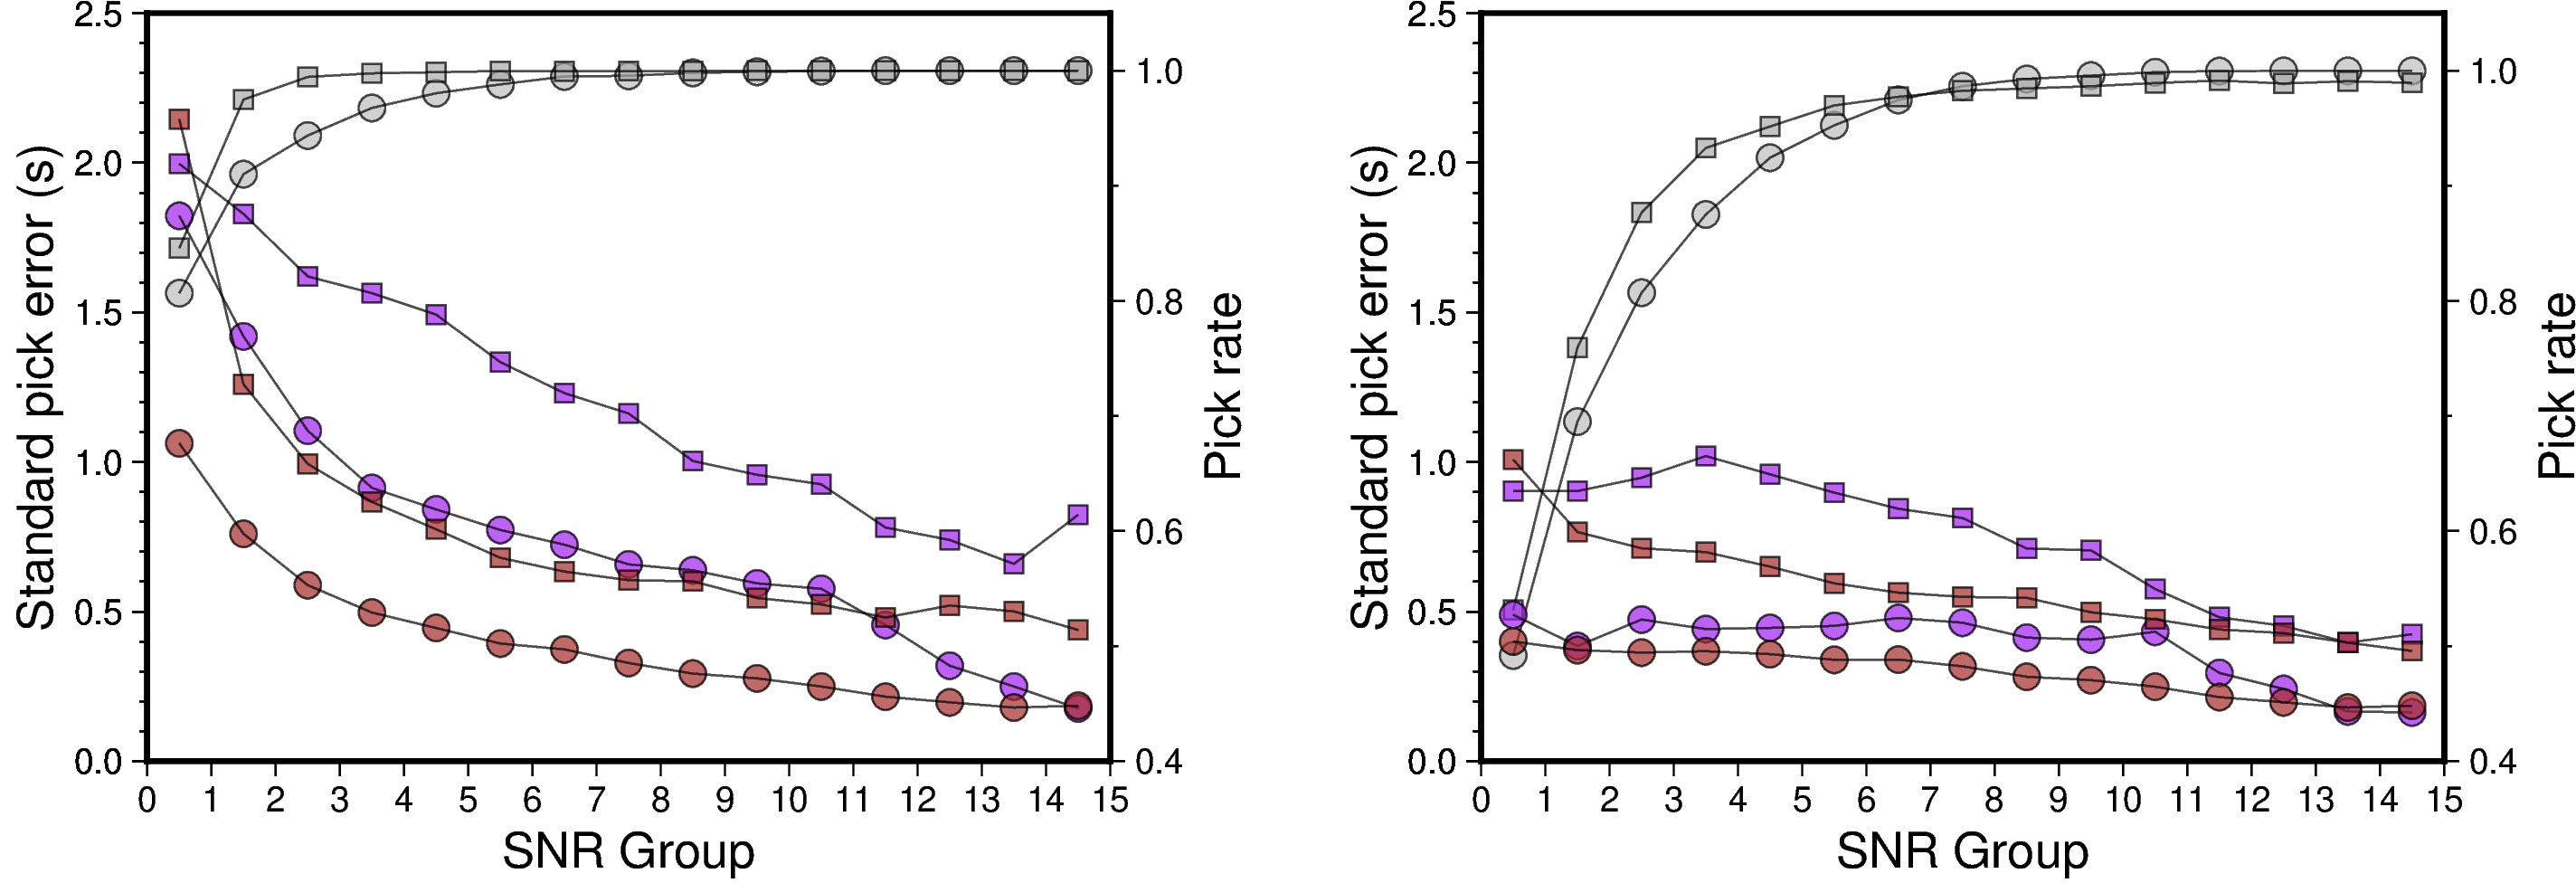

In [14]:
# plot picking rate instead of number of picks
fig = pygmt.Figure()
# Bottom row, two subplots
with fig.subplot(nrows=1, ncols=2, figsize=("21.5c", "7c"), autolabel=None, margins=["1.5c", "0c"]):
    # fig.legend(position="jBR+o0.2c", box=True)         
    # ======= Plot for ensemble-simple ========
    fig.basemap(
        region=region4d, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 0]
    )
    with fig.set_panel(panel=[0, 0]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3d,frame=['E', 'yaf+l"Pick rate"'])  
        # plot for ppicks detections
        SFB_p_stats_list = []
        for ifolder in range(nfolders): 
            SFB_nppicks = int(p_pick_stats_list3[ifolder,0])/(ntrace_list[ifolder]-3000)
            SFB_p_stats_list.append(SFB_nppicks)
        x, y = np.arange(0.5, nfolders+0.5), SFB_p_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill[0],
            error_bar = False,
            transparency = transparency,
            # label = 'P-pick rate (ensemble)'
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )
        # plot for spicks detections
        SFB_s_stats_list = []
        for ifolder in range(nfolders): 
            SFB_nspicks = int(s_pick_stats_list3[ifolder,0])/(ntrace_list[ifolder]-3000)
            SFB_s_stats_list.append(SFB_nspicks)
        x, y = np.arange(0.5, nfolders+0.5), SFB_s_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill[1],
            error_bar = False,
            transparency = transparency,
            # label = 'S-pick rate (ensemble)'
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )
        
        # fig.legend(position="J1c/8c+w5/3+jBL+o0.2c", box=True)  
        
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
           fig.basemap(region=region4p, frame=["W", 'ya0.5f0.1+l"Standard pick error (s)"']) 
           
        # ========= ensemble maximum
        # plot ppick mean and std    
        SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_p_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
        # plot spick mean and std    
        SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_s_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
        # ========= ensemble maximum + learning
        # plot ppick mean and std    
        SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list3) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_p_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        # plot spick mean and std    
        SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list3) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_s_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
    # ======= Plot for ensemble-semblance ========
    fig.basemap(
        region=region4p, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 1]
    )
    with fig.set_panel(panel=[0, 1]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3d,frame=['E', 'yaf+l"Pick rate"'])   
            
        # plot for ppicks detections
        SFB_p_stats_list2 = []
        for ifolder in range(nfolders): 
            SFB_nppicks2 = int(p_pick_stats_list3[ifolder,3])/(ntrace_list[ifolder]-3000)
            SFB_p_stats_list2.append(SFB_nppicks2)
        x, y = np.arange(0.5, nfolders+0.5), SFB_p_stats_list2
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill[0],
            error_bar = False,
            transparency = transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )    
        
        # plot for spicks detections
        SFB_s_stats_list2 = []
        for ifolder in range(nfolders): 
            SFB_nspicks2 = int(s_pick_stats_list3[ifolder,3])/(ntrace_list[ifolder]-3000)
            SFB_s_stats_list2.append(SFB_nspicks2)
        x, y = np.arange(0.5, nfolders+0.5), SFB_s_stats_list2
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nfolders,]),
            "y-error": np.zeros([nfolders,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill[1],
            error_bar = False,
            transparency = transparency,
        )   
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        ) 
        
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
           fig.basemap(region=region4s, frame=["W", 'ya0.5f0.1+l"Standard pick error (s)"']) 
        
        # ======== ensemble semblance
        # plot ppick mean and std    
        SFB_p_pick_stats_list2 = np.squeeze(p_pick_stats_list2) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_p_pick_stats_list2[:,2]
        x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
        # plot spick mean and std    
        SFB_s_pick_stats_list2 = np.squeeze(s_pick_stats_list2) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_s_pick_stats_list2[:,2]
        x_err, y_err = np.zeros([nfolders,]), np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
           
        # ======== ensemble semblance + learning
        # plot ppick mean and std    
        SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list3) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_p_pick_stats_list[:,5]
        x_err, y_err = np.zeros([nfolders,]),np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        # plot spick mean and std    
        SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list3) 
        x, y = np.arange(0.5, nfolders+0.5), SFB_s_pick_stats_list[:,5]
        x_err, y_err = np.zeros([nfolders,]),np.zeros([nfolders,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
fig.show()

### Figures for PNW case
Note: uneven earthquake numbers at different SNR groups.

#### load prediction results from all pretrained models

In [15]:
# read data
dirpath_csv = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/PNW_prediction/results/'
prefix = 'fullband_'
prefix2 = 'multiband_'
# model_name_list = ["eqt_original","eqt_ethz","eqt_instance","eqt_scedc","eqt_stead", "eqt_lendb","eqt_neic"]
model_name_list = ["eqt_original","eqt_ethz","eqt_instance","eqt_scedc","eqt_stead", "eqt_neic"]

# read overall metadata for dropping some data
meta = pd.read_csv(dirpath_csv+"comcat_metadata.csv")

# P/S arrival should be in 4500 - 10000
ind_drop_list = meta[(meta['trace_P_arrival_sample'] < 4500) | (meta['trace_S_arrival_sample'] > 10000)].index

In [16]:
# count and categorize
# initializing
nsnrs, nmodels = 15, len(model_name_list)
dt, nt = 0.01, 6000
ntrace_list = np.zeros([nmodels,nsnrs], dtype=int)
detect_stats_list = np.zeros([nmodels, nsnrs], dtype=int) # count of detections 
p_pick_stats_list = np.zeros([nmodels, nsnrs, 4]) # 0: count, 1: average; 2: standard deviation; 3. absolute error
s_pick_stats_list = np.zeros([nmodels, nsnrs, 4]) # 0: count, 1: average; 2: standard deviation; 3. absolute error

detect_stats_mbf_list = np.zeros([nmodels, nsnrs], dtype=int) 
p_pick_stats_mbf_list = np.zeros([nmodels, nsnrs, 4]) 
s_pick_stats_mbf_list = np.zeros([nmodels, nsnrs, 4])

misfit_p_target_list, misfit_s_target_list = [], []
misfit_p_target_mbf_list, misfit_s_target_mbf_list = [], []
mdl_target = "eqt_scedc"

for imdl, mdlnm in enumerate(model_name_list):
    flnm = prefix + mdlnm
    flnm2 = prefix2 + mdlnm
    # load original predictions
    csv_signal = pd.read_csv(dirpath_csv+flnm+'.csv')
    trace_nam_list = np.delete(csv_signal['trace_name'].values, ind_drop_list)
    p_arrival_sample_list = np.delete(csv_signal['p_arrival_sample'].values, ind_drop_list)
    s_arrival_sample_list = np.delete(csv_signal['s_arrival_sample'].values, ind_drop_list)
    pred_d_arrival_time_list = np.delete(csv_signal['pred_d_arrival_sample'].values,ind_drop_list) # wrong header name in csv
    pred_p_arrival_time_list = np.delete(csv_signal['pred_p_arrival_sample'].values,ind_drop_list) # should be time not sample
    pred_s_arrival_time_list = np.delete(csv_signal['pred_s_arrival_sample'].values,ind_drop_list)
    trace_snr_list = np.delete(csv_signal['trace_snr_averaged_db'].values,ind_drop_list)
    
    # load mbf predictions
    csv_signal_mbf = pd.read_csv(dirpath_csv+flnm2+'.csv')
    trace_nam_mbf_list = np.delete(csv_signal_mbf['trace_name'].values, ind_drop_list)
    p_arrival_sample_mbf_list = np.delete(csv_signal_mbf['p_arrival_sample'].values,ind_drop_list)
    s_arrival_sample_mbf_list = np.delete(csv_signal_mbf['s_arrival_sample'].values,ind_drop_list)
    pred_d_arrival_time_mbf_list = np.delete(csv_signal_mbf['pred_d_arrival_sample'].values,ind_drop_list)
    pred_p_arrival_time_mbf_list = np.delete(csv_signal_mbf['pred_p_arrival_sample'].values,ind_drop_list)
    pred_s_arrival_time_mbf_list = np.delete(csv_signal_mbf['pred_s_arrival_sample'].values,ind_drop_list)
    
    # get snr range
    snr_min, snr_max = np.min(trace_snr_list), np.max(trace_snr_list)
    print(f'snr_min, snr_max = {snr_min}, {snr_max}')
    snr_thres_pairs = [(-2,2),(2,4),(4,6),(6,8),(8,10),(10,12),(12,14),(14,16),(16,18),(18,20),(20,25),(25,30),(30,35),(35,40),(40, snr_max)]
    
    for isnr, snr_pair in enumerate(snr_thres_pairs):
        snr1, snr2 = snr_pair
        ind_list = np.where((trace_snr_list>snr1)&(trace_snr_list<=snr2))[0]
        ntrace_list[imdl, isnr] = len(ind_list)
        
        # inspection and analysis
        d_count = 0
        misfit_p_list, misfit_s_list = [], []
        for itr in ind_list:
            # P picks
            true_p = float(p_arrival_sample_list[itr])*dt
            pred_p = pred_p_arrival_time_list[itr] 
            if ~np.isnan(pred_p):
                pred_p = float(pred_p)
                misfit_p_list.append(pred_p-true_p)
            # S picks
            true_s = float(s_arrival_sample_list[itr])*dt
            pred_s = pred_s_arrival_time_list[itr] 
            if ~np.isnan(pred_s):
                pred_s = float(pred_s)
                misfit_s_list.append(pred_s-true_s)
            # detection
            pred_d = pred_d_arrival_time_list[itr] 
            if type(pred_d)==str:
                d_count += 1
        
        # append misfits
        if mdlnm == mdl_target:
            misfit_p_target_list.append(misfit_p_list)
            misfit_s_target_list.append(misfit_s_list)
                   
        # inspection and analysis for mbf
        d_count_mbf = 0
        misfit_p_mbf_list, misfit_s_mbf_list = [], []
        for itr in ind_list:
            # P picks
            true_p = float(p_arrival_sample_mbf_list[itr])*dt
            pred_p = pred_p_arrival_time_mbf_list[itr] 
            if ~np.isnan(pred_p):
                pred_p = float(pred_p)
                misfit_p_mbf_list.append(pred_p-true_p)
            # S picks
            true_s = float(s_arrival_sample_mbf_list[itr])*dt
            pred_s = pred_s_arrival_time_mbf_list[itr] 
            if ~np.isnan(pred_s):
                pred_s = float(pred_s)
                misfit_s_mbf_list.append(pred_s-true_s)
            # detection
            pred_d = pred_d_arrival_time_mbf_list[itr] 
            if type(pred_d)==str:
                d_count_mbf += 1
                
        # append misfits
        if mdlnm == mdl_target:
            misfit_p_target_mbf_list.append(misfit_p_list)
            misfit_s_target_mbf_list.append(misfit_s_list)
            
        # statistics and write metrics
        misfit_p_list, misfit_p_mbf_list = np.array(misfit_p_list), np.array(misfit_p_mbf_list)
        misfit_s_list, misfit_s_mbf_list = np.array(misfit_s_list), np.array(misfit_s_mbf_list)
        detect_stats_list[imdl,isnr], detect_stats_mbf_list[imdl,isnr]= d_count, d_count_mbf
        
        p_pick_stats_list[imdl,isnr,0], p_pick_stats_mbf_list[imdl,isnr,0] = len(misfit_p_list), len(misfit_p_mbf_list)
        p_pick_stats_list[imdl,isnr,1], p_pick_stats_mbf_list[imdl,isnr,1] = np.mean(misfit_p_list[np.abs(misfit_p_list)<=2.0]), np.mean(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=2.0])
        p_pick_stats_list[imdl,isnr,2], p_pick_stats_mbf_list[imdl,isnr,2] = np.std(misfit_p_list[np.abs(misfit_p_list)<=10.0]), np.std(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0])
        p_pick_stats_list[imdl,isnr,3], p_pick_stats_mbf_list[imdl,isnr,3] = np.mean(np.abs(misfit_p_list[np.abs(misfit_p_list)<=10.0])), np.mean(np.abs(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0]))
        
        s_pick_stats_list[imdl,isnr,0], s_pick_stats_mbf_list[imdl,isnr,0] = len(misfit_s_list), len(misfit_s_mbf_list)
        s_pick_stats_list[imdl,isnr,1], s_pick_stats_mbf_list[imdl,isnr,1] = np.mean(misfit_s_list[np.abs(misfit_s_list)<=2.0]), np.mean(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=2.0])
        s_pick_stats_list[imdl,isnr,2], s_pick_stats_mbf_list[imdl,isnr,2] = np.std(misfit_s_list[np.abs(misfit_s_list)<=10.0]), np.std(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0])
        s_pick_stats_list[imdl,isnr,3], s_pick_stats_mbf_list[imdl,isnr,3] = np.mean(np.abs(misfit_s_list[np.abs(misfit_s_list)<=10.0])), np.mean(np.abs(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0]))
        

snr_min, snr_max = -17.748, 76.92
snr_min, snr_max = -17.748, 76.92
snr_min, snr_max = -17.748, 76.92
snr_min, snr_max = -17.748, 76.92
snr_min, snr_max = -17.748, 76.92
snr_min, snr_max = -17.748, 76.92


In [17]:
# assemble
imdl = 3
SFB_detect_stats_hist, MFB_detect_stats_hist = [], []
SFB_detect_stats_list, MFB_detect_stats_list = [], [] # detection rate
SFB_p_stats_hist, MFB_p_stats_hist = [], []
SFB_s_stats_hist, MFB_s_stats_hist = [], []
for ifolder in range(nsnrs):
    SFB_ndetects = detect_stats_list[imdl,ifolder]
    MFB_ndetects = detect_stats_mbf_list[imdl,ifolder]
    SFB_detect_stats_list.append(SFB_ndetects/ntrace_list[imdl,ifolder])
    MFB_detect_stats_list.append(MFB_ndetects/ntrace_list[imdl,ifolder])
    SFB_nppicks = int(p_pick_stats_list[imdl,ifolder,0])
    MFB_nppicks = int(p_pick_stats_mbf_list[imdl,ifolder,0])
    SFB_nspicks = int(s_pick_stats_list[imdl,ifolder,0])
    MFB_nspicks = int(s_pick_stats_mbf_list[imdl,ifolder,0])
    for id in range(SFB_ndetects):
        SFB_detect_stats_hist.append(ifolder)
    for id in range(MFB_ndetects):
        MFB_detect_stats_hist.append(ifolder)
    for id in range(SFB_nppicks):
        SFB_p_stats_hist.append(ifolder)
    for id in range(MFB_nppicks):
        MFB_p_stats_hist.append(ifolder)
    for id in range(SFB_nspicks):
        SFB_s_stats_hist.append(ifolder)
    for id in range(MFB_nspicks):
        MFB_s_stats_hist.append(ifolder)
           
SFB_p_pick_stats_list, SFB_s_pick_stats_list = np.squeeze(p_pick_stats_list[imdl]), np.squeeze(s_pick_stats_list[imdl])    
MFB_p_pick_stats_list, MFB_s_pick_stats_list = np.squeeze(p_pick_stats_mbf_list[imdl]), np.squeeze(s_pick_stats_mbf_list[imdl]) 


#### plot prediction results from all pretrained models

In [18]:
# plotting parameters 
region = [0, nsnrs, 0, 25000]
region2 = [0, nsnrs, -9.0, 1.]
region2p = [0, nsnrs, -6.0, 2.0]
region2s = [0, nsnrs, -6.0, 2.0]
region2d = [0, nsnrs, 0.8, 1.2]
region3d = [0, nsnrs, 0.5, 1.1]
region3p = [0, nsnrs, 0.5, 1.5] # for pick rate
region3s = [0, nsnrs, 0.5, 1.5]
region4p = [0, nsnrs, -2, 2]
region4s = [0, nsnrs, -2, 2]
frame = ['wsne', 'x', 'y']
frame2 = ['wsnE', 'x', 'y+l"Trace counts"']
series = 1
series2 = 1
styles = ["c", "d", "h", "i", "s", "t"]
cfill = ["gray", "gray", "black", "black"]
cfill2 = ["black", "black", "black", "black"]
cfill3 = ["darkorange1", "blue", "seagreen", "red4"]
pen = "1p"
histtype = 0
transparency=50

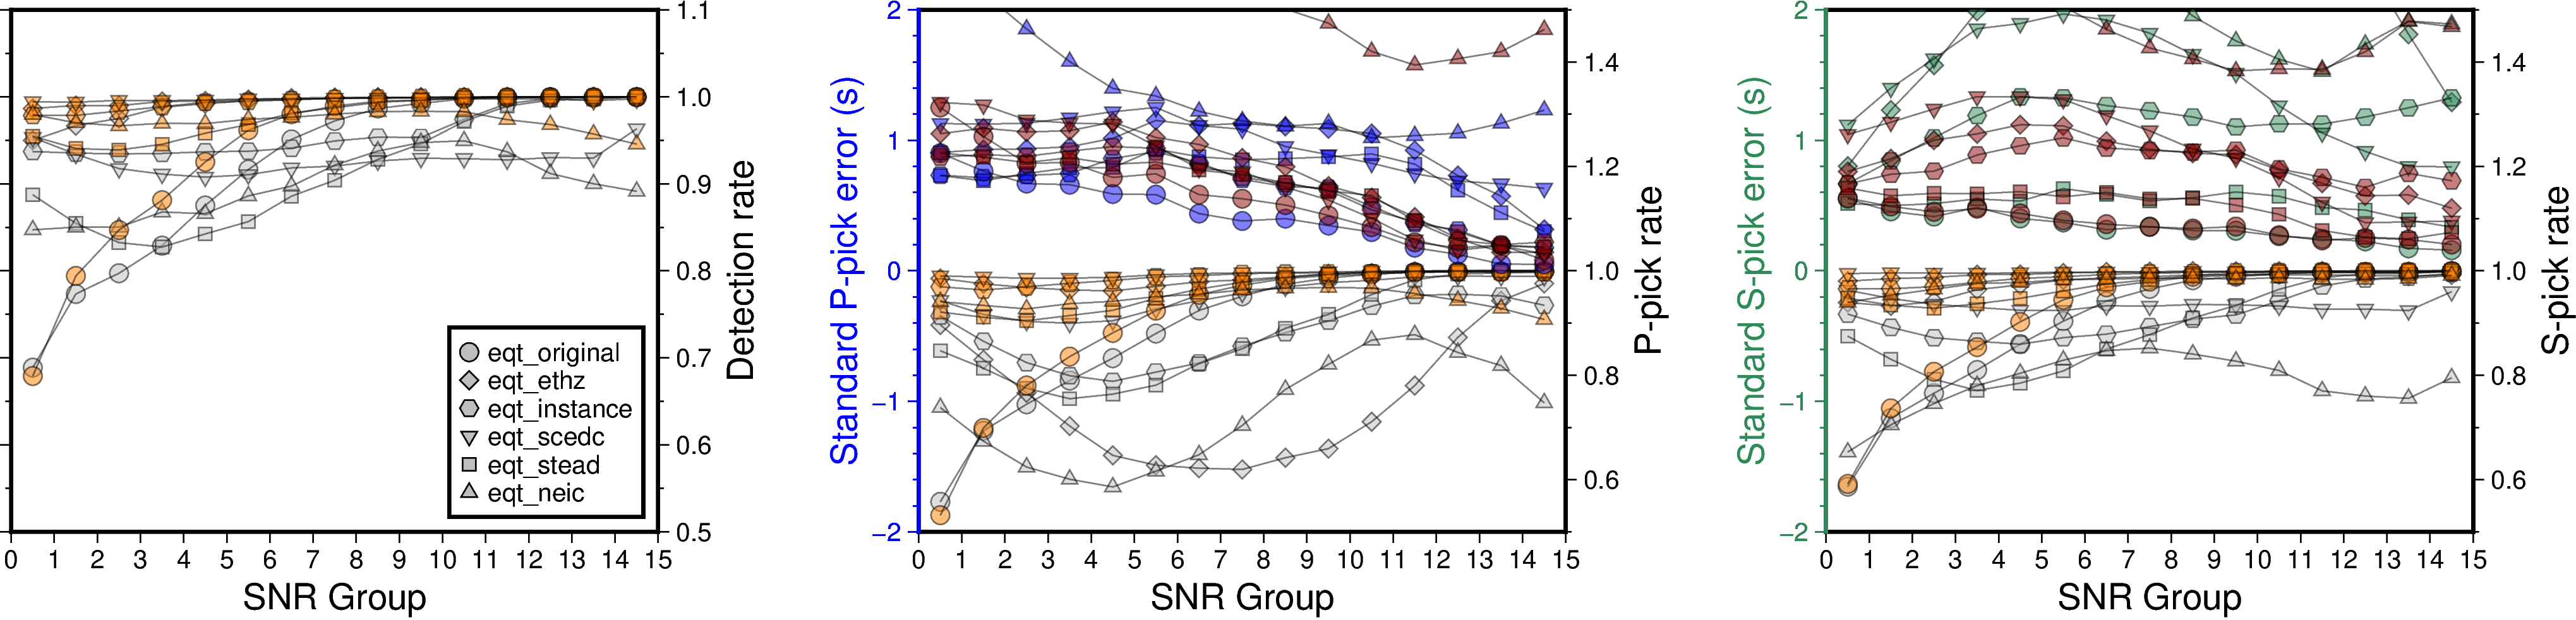

In [19]:
fig = pygmt.Figure()
# Bottom row, two subplots
with fig.subplot(nrows=1, ncols=3, figsize=("33c", "7c"), autolabel=None, margins=["1.5c", "0c"]):
    fig.basemap(
        region=region3d, projection="X?", frame=["S", 'xa1f1+l"SNR Group"'], panel=[0, 0]
    )
    with fig.set_panel(panel=[0, 0]):
        # ===== Plot for detection =======
        # plot for left axis
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(frame=["nw", 'ya0.1f0.05+l"Count of detections"'])  
        
        
            # # plot markers
            # fig.plot(
            #     data=df.to_numpy(),
            #     style=styles[imdl]+"0.25c",
            #     pen="0.5p,black",
            #     color=cfill[0],
            #     error_bar = False,
            #     transparency = transparency,
            #     # label = mdlnm
            # )
            # # plot line
            # fig.plot(
            #     x=x,
            #     y=y,
            #     pen="0.5p,black",
            #     transparency = transparency
            # )
        
        # plot for the right axis
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
           fig.basemap(region=region3d, frame=["E", 'ya0.1f0.05+l"Detection rate"']) 
        
        for imdl, mdlnm in enumerate(model_name_list):
            SFB_detect_stats_list = []
            for ifolder in range(nsnrs): 
                SFB_ndetects = detect_stats_list[imdl,ifolder]
                SFB_detect_stats_list.append(SFB_ndetects/ntrace_list[imdl, ifolder])
            x, y = np.arange(0.5, nsnrs+0.5), SFB_detect_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nsnrs,]),
                "y-error": np.zeros([nsnrs,]),
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill[0],
                error_bar = False,
                transparency = transparency,
                label = mdlnm
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        
        # ==== for MBF
        for imdl, mdlnm in enumerate(model_name_list):
            MFB_detect_stats_list = []
            for ifolder in range(nsnrs): 
                MFB_ndetects = detect_stats_mbf_list[imdl,ifolder]
                MFB_detect_stats_list.append(MFB_ndetects/ntrace_list[imdl, ifolder])
            x, y = np.arange(0.5, nsnrs+0.5), MFB_detect_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nsnrs,]),
                "y-error": np.zeros([nsnrs,]),
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[0],
                error_bar = False,
                transparency = transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        
    fig.legend(position="jBR+o0.2c", box=True)         
    # ======= Plot for P picks ========
    fig.basemap(region=region4p, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 1]
    )
    with fig.set_panel(panel=[0, 1]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3p, frame=['E', 'yaf+l"P-pick rate"'])  
        
        for imdl, mdlnm in enumerate(model_name_list):
            SFB_p_stats_list = []
            for ifolder in range(nsnrs): 
                SFB_nppicks = int(p_pick_stats_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                SFB_p_stats_list.append(SFB_nppicks)
            x, y = np.arange(0.5, nsnrs+0.5), SFB_p_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nsnrs,]),
                "y-error": np.zeros([nsnrs,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill[0],
                error_bar = False,
                transparency = transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
        
        # ====== MBF
        for imdl, mdlnm in enumerate(model_name_list):
            MFB_p_stats_list = []
            for ifolder in range(nsnrs): 
                MFB_nppicks = int(p_pick_stats_mbf_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                MFB_p_stats_list.append(MFB_nppicks)
            x, y = np.arange(0.5, nsnrs+0.5), MFB_p_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nsnrs,]),
                "y-error": np.zeros([nsnrs,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[0],
                error_bar = False,
                transparency = transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
        
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN=cfill3[1],
            MAP_TICK_PEN=cfill3[1],
            FONT_ANNOT_PRIMARY=cfill3[1],
            FONT_LABEL=cfill3[1],
        ):
           fig.basemap(region=region4p, frame=["W", 'ya1.0f0.2+l"Standard P-pick error (s)"']) 
        
        for imdl, mdlnm in enumerate(model_name_list):     
            SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list[imdl]) 
            x, y = np.arange(0.5, nsnrs+0.5), SFB_p_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[1],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        # ====== MBF
        for imdl, mdlnm in enumerate(model_name_list):     
            MFB_p_pick_stats_list = np.squeeze(p_pick_stats_mbf_list[imdl]) 
            x, y = np.arange(0.5, nsnrs+0.5), MFB_p_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[3],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            )
        
    # ======= Plot for S picks ========
    fig.basemap(region=region4s, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 2]
    )
    with fig.set_panel(panel=[0, 2]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3s, frame=['E', 'yaf+l"S-pick rate"'])   
            
        for imdl, mdlnm in enumerate(model_name_list):
            SFB_s_stats_list = []
            for ifolder in range(nsnrs): 
                SFB_nppicks = int(s_pick_stats_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                SFB_s_stats_list.append(SFB_nppicks)
            x, y = np.arange(0.5, nsnrs+0.5), SFB_s_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nsnrs,]),
                "y-error": np.zeros([nsnrs,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill[0],
                error_bar = False,
                transparency = transparency
            )   
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
        
        # ======== MBF
        for imdl, mdlnm in enumerate(model_name_list):
            MFB_s_stats_list = []
            for ifolder in range(nsnrs): 
                MFB_nppicks = int(s_pick_stats_mbf_list[imdl,ifolder,0])/ntrace_list[imdl,ifolder]
                MFB_s_stats_list.append(MFB_nppicks)
            x, y = np.arange(0.5, nsnrs+0.5), MFB_s_stats_list
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": np.zeros([nsnrs,]),
                "y-error": np.zeros([nsnrs,]),
            }
            )  
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[0],
                error_bar = False,
                transparency = transparency
            )   
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency = transparency
            )
                
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN=cfill3[2],
            MAP_TICK_PEN=cfill3[2],
            FONT_ANNOT_PRIMARY=cfill3[2],
            FONT_LABEL=cfill3[2],
        ):
           fig.basemap(region=region4s, frame=["W", 'ya1.0f0.2+l"Standard S-pick error (s)"']) 
        for imdl, mdlnm in enumerate(model_name_list):     
            SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list[imdl]) 
            x, y = np.arange(0.5, nsnrs+0.5), SFB_s_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[2],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            ) 
        
        # ====== MBF
        for imdl, mdlnm in enumerate(model_name_list):     
            MFB_s_pick_stats_list = np.squeeze(s_pick_stats_mbf_list[imdl]) 
            x, y = np.arange(0.5, nsnrs+0.5), MFB_s_pick_stats_list[:,2]
            x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
            df = pd.DataFrame(
            data={
                "x": x,
                "y": y,
                "x-error": x_err,
                "y-error": y_err,
            }
            )
            # plot markers
            fig.plot(
                data=df.to_numpy(),
                style=styles[imdl]+"0.25c",
                pen="0.5p,black",
                color=cfill3[3],
                error_bar = False,
                transparency=transparency
            )
            # plot line
            fig.plot(
                x=x,
                y=y,
                pen="0.5p,black",
                transparency=transparency
            ) 
            
fig.show()


#### load ensemble estimation and transfer-learning results

In [20]:
# load predictions
dirpath_root = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/PNW_prediction/results_ensemble/'
# dirpath_root = '/Users/jackie_yuan/Downloads/ensemble_PNW/'

dirpath_ensemble_original = dirpath_root+'pnw_simple/'
dirpath_ensemble_mbf = dirpath_root+'pnw_simple/'

dirpath_tf_original = dirpath_root+'pnw_tf/'
dirpath_tf_mbf = dirpath_root+'pnw_tf/'

dirpath_ensemble_learner_original = dirpath_root+'pnw_metalearner/' 
dirpath_ensemble_learner_mbf = dirpath_root+'pnw_metalearner/'

In [21]:
# read data
dirpath_csv = '/Volumes/GD-cyuan/DataYuan/INSTANCE/dataset/processed/Ensemble/PNW_prediction/results/'

# read overall metadata for dropping some data
meta = pd.read_csv(dirpath_csv+"comcat_metadata.csv")

# P/S arrival should be in 4500 - 10000
ind_drop_list = meta[(meta['trace_P_arrival_sample'] < 4500) | (meta['trace_S_arrival_sample'] > 10000)].index

In [22]:
# get index for testing data in different ensemble datasets
flnm = 'fullband_PNW'
# load learning predictions
csv_signal = pd.read_csv(dirpath_ensemble_learner_original+flnm+'.csv') # same with the mbf name list
target_trace_nam_list = csv_signal['trace_name'].values

In [23]:
# count and categorize
# initializing
nsnrs = 15
dt, nt = 0.01, 6000
ntrace_list = np.zeros([nsnrs,], dtype=int)
flnm = 'fullband_semblance_maximum_pnw' 
flnm2 = 'multiband_semblance_maximum_pnw'

p_pick_stats_list = np.zeros([nsnrs, 4]) # 0: count, 1: average; 2: standard deviation
s_pick_stats_list = np.zeros([nsnrs, 4]) # 0: count, 1: average; 2: standard deviation
p_pick_stats_mbf_list = np.zeros([nsnrs, 4]) 
s_pick_stats_mbf_list = np.zeros([nsnrs, 4])

p_pick_stats_list2 = np.zeros([nsnrs, 4]) 
s_pick_stats_list2 = np.zeros([nsnrs, 4]) 
p_pick_stats_mbf_list2 = np.zeros([nsnrs, 4]) 
s_pick_stats_mbf_list2 = np.zeros([nsnrs, 4])

misfit_p_index_list, misfit_s_index_list = [], []
misfit_p_index_mbf_list, misfit_s_index_mbf_list = [], []
misfit_p_index_list2, misfit_s_index_list2 = [], []
misfit_p_index_mbf_list2, misfit_s_index_mbf_list2 = [], []

# load original predictions
df = pd.read_csv(dirpath_ensemble_original+flnm+'.csv')
csv_signal = df[df['trace_name'].isin(target_trace_nam_list.tolist())]
trace_nam_list = csv_signal['trace_name'].values
p_arrival_sample_list = csv_signal['trace_P_arrival_sample'].values
s_arrival_sample_list = csv_signal['trace_S_arrival_sample'].values
trace_snr_list = csv_signal['trace_snr_averaged_db'].values
# ensemble-maximum
pred_p_arrival_time_list = csv_signal['pred_p_arrival_time'].values
pred_s_arrival_time_list = csv_signal['pred_s_arrival_time'].values
# ensemble-semblance
pred_p_arrival_time_list2 = csv_signal['pred_p_arrival_time2'].values
pred_s_arrival_time_list2 = csv_signal['pred_s_arrival_time2'].values

# load mbf predictions
df = pd.read_csv(dirpath_ensemble_mbf+flnm2+'.csv')
csv_signal_mbf = df[df['trace_name'].isin(target_trace_nam_list.tolist())]
p_arrival_sample_mbf_list = csv_signal_mbf['trace_P_arrival_sample'].values
s_arrival_sample_mbf_list = csv_signal_mbf['trace_S_arrival_sample'].values
# ensemble-maximum
pred_p_arrival_time_mbf_list = csv_signal_mbf['pred_p_arrival_time'].values
pred_s_arrival_time_mbf_list = csv_signal_mbf['pred_s_arrival_time'].values
# ensemble-semblance
pred_p_arrival_time_mbf_list2 = csv_signal_mbf['pred_p_arrival_time2'].values
pred_s_arrival_time_mbf_list2 = csv_signal_mbf['pred_s_arrival_time2'].values
    
# get snr range
snr_min, snr_max = np.min(trace_snr_list), np.max(trace_snr_list)
print(f'snr_min, snr_max = {snr_min}, {snr_max}')
snr_thres_pairs = [(-2,2),(2,4),(4,6),(6,8),(8,10),(10,12),(12,14),(14,16),(16,18),(18,20),(20,25),(25,30),(30,35),(35,40),(40, snr_max)]

for isnr, snr_pair in enumerate(snr_thres_pairs):
    snr1, snr2 = snr_pair
    ind_list = np.where((trace_snr_list>snr1)&(trace_snr_list<=snr2))[0]
    ntrace_list[isnr] = len(ind_list)
    
    # inspection and analysis
    misfit_p_list, misfit_s_list = [], []
    misfit_p_list2, misfit_s_list2 = [], []
    misfit_p_indexes, misfit_s_indexes = [], []
    misfit_p_indexes2, misfit_s_indexes2 = [], []
    for itr in ind_list:
        # P picks - maximum
        true_p = float(p_arrival_sample_list[itr])*dt
        pred_p = pred_p_arrival_time_list[itr] 
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_list.append(pred_p-true_p)
            # append index
            misfit_p_indexes.append(itr)
        # S picks - maximum
        true_s = float(s_arrival_sample_list[itr])*dt
        pred_s = pred_s_arrival_time_list[itr] 
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_list.append(pred_s-true_s)
            # append index
            misfit_s_indexes.append(itr)
        # P picks - semblance
        true_p = float(p_arrival_sample_list[itr])*dt
        pred_p2 = pred_p_arrival_time_list2[itr] 
        if ~np.isnan(pred_p2):
            pred_p2 = float(pred_p2)
            misfit_p_list2.append(pred_p2-true_p)
            # append index
            misfit_p_indexes2.append(itr)
        # S picks - semblance
        true_s = float(s_arrival_sample_list[itr])*dt
        pred_s2 = pred_s_arrival_time_list2[itr] 
        if ~np.isnan(pred_s2):
            pred_s = float(pred_s2)
            misfit_s_list2.append(pred_s2-true_s)
            # append index
            misfit_s_indexes2.append(itr)
        
    # append index
    misfit_p_index_list.append(misfit_p_indexes)
    misfit_s_index_list.append(misfit_s_indexes)
    misfit_p_index_list2.append(misfit_p_indexes2)
    misfit_s_index_list2.append(misfit_s_indexes2)
        
    # inspection and analysis for mbf
    misfit_p_mbf_list, misfit_s_mbf_list = [], []
    misfit_p_mbf_list2, misfit_s_mbf_list2 = [], []
    misfit_p_indexes, misfit_s_indexes = [], []
    misfit_p_indexes2, misfit_s_indexes2 = [], []
    for itr in ind_list:
        # P picks - maximum
        true_p = float(p_arrival_sample_mbf_list[itr])*dt
        pred_p = pred_p_arrival_time_mbf_list[itr] 
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_mbf_list.append(pred_p-true_p)
            # append index
            misfit_p_indexes.append(itr)
        # S picks - maximum
        true_s = float(s_arrival_sample_mbf_list[itr])*dt
        pred_s = pred_s_arrival_time_mbf_list[itr] 
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_mbf_list.append(pred_s-true_s)
            # append index
            misfit_s_indexes.append(itr)
        # P picks - semblance
        true_p = float(p_arrival_sample_mbf_list[itr])*dt
        pred_p2 = pred_p_arrival_time_mbf_list2[itr] 
        if ~np.isnan(pred_p2):
            pred_p = float(pred_p2)
            misfit_p_mbf_list2.append(pred_p2-true_p)
            # append index
            misfit_p_indexes2.append(itr)
        # S picks - semblance
        true_s = float(s_arrival_sample_mbf_list[itr])*dt
        pred_s2 = pred_s_arrival_time_mbf_list2[itr] 
        if ~np.isnan(pred_s2):
            pred_s2 = float(pred_s2)
            misfit_s_mbf_list2.append(pred_s2-true_s)
            # append index
            misfit_s_indexes2.append(itr)
            
    # append index
    misfit_p_index_mbf_list.append(misfit_p_indexes)
    misfit_s_index_mbf_list.append(misfit_s_indexes)
    misfit_p_index_mbf_list2.append(misfit_p_indexes2)
    misfit_s_index_mbf_list2.append(misfit_s_indexes2)
        
    # statistical analysis    
    misfit_p_list, misfit_p_mbf_list = np.array(misfit_p_list), np.array(misfit_p_mbf_list)
    misfit_s_list, misfit_s_mbf_list = np.array(misfit_s_list), np.array(misfit_s_mbf_list)
    misfit_p_list2, misfit_p_mbf_list2 = np.array(misfit_p_list2), np.array(misfit_p_mbf_list2)
    misfit_s_list2, misfit_s_mbf_list2 = np.array(misfit_s_list2), np.array(misfit_s_mbf_list2)

    p_pick_stats_list[isnr,0], p_pick_stats_mbf_list[isnr,0] = len(misfit_p_list), len(misfit_p_mbf_list)
    p_pick_stats_list[isnr,1], p_pick_stats_mbf_list[isnr,1] = np.mean(misfit_p_list[np.abs(misfit_p_list)<=2.0]), np.mean(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=2.0])
    p_pick_stats_list[isnr,2], p_pick_stats_mbf_list[isnr,2] = np.std(misfit_p_list[np.abs(misfit_p_list)<=10.0]), np.std(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0])
    p_pick_stats_list[isnr,3], p_pick_stats_mbf_list[isnr,3] = np.mean(np.abs(misfit_p_list[np.abs(misfit_p_list)<=10.0])), np.mean(np.abs(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0]))

    s_pick_stats_list[isnr,0], s_pick_stats_mbf_list[isnr,0] = len(misfit_s_list), len(misfit_s_mbf_list)
    s_pick_stats_list[isnr,1], s_pick_stats_mbf_list[isnr,1] = np.mean(misfit_s_list[np.abs(misfit_s_list)<=2.0]), np.mean(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=2.0])
    s_pick_stats_list[isnr,2], s_pick_stats_mbf_list[isnr,2] = np.std(misfit_s_list[np.abs(misfit_s_list)<=10.0]), np.std(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0])
    s_pick_stats_list[isnr,3], s_pick_stats_mbf_list[isnr,3] = np.mean(np.abs(misfit_s_list[np.abs(misfit_s_list)<=10.0])), np.mean(np.abs(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0]))

    p_pick_stats_list2[isnr,0], p_pick_stats_mbf_list2[isnr,0] = len(misfit_p_list2), len(misfit_p_mbf_list2)
    p_pick_stats_list2[isnr,1], p_pick_stats_mbf_list2[isnr,1] = np.mean(misfit_p_list2[np.abs(misfit_p_list2)<=2.0]), np.mean(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=2.0])
    p_pick_stats_list2[isnr,2], p_pick_stats_mbf_list2[isnr,2] = np.std(misfit_p_list2[np.abs(misfit_p_list2)<=10.0]), np.std(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=10.0])
    p_pick_stats_list2[isnr,3], p_pick_stats_mbf_list2[isnr,3] = np.mean(np.abs(misfit_p_list2[np.abs(misfit_p_list2)<=10.0])), np.mean(np.abs(misfit_p_mbf_list2[np.abs(misfit_p_mbf_list2)<=10.0]))
    
    s_pick_stats_list2[isnr,0], s_pick_stats_mbf_list2[isnr,0] = len(misfit_s_list2), len(misfit_s_mbf_list2)
    s_pick_stats_list2[isnr,1], s_pick_stats_mbf_list2[isnr,1] = np.mean(misfit_s_list2[np.abs(misfit_s_list2)<=2.0]), np.mean(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=2.0])
    s_pick_stats_list2[isnr,2], s_pick_stats_mbf_list2[isnr,2] = np.std(misfit_s_list2[np.abs(misfit_s_list2)<=10.0]), np.std(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=10.0])
    s_pick_stats_list2[isnr,3], s_pick_stats_mbf_list2[isnr,3] = np.mean(np.abs(misfit_s_list2[np.abs(misfit_s_list2)<=10.0])), np.mean(np.abs(misfit_s_mbf_list2[np.abs(misfit_s_mbf_list2)<=10.0]))
   

snr_min, snr_max = -17.748, 73.581


In [24]:
# count and categorize
# initializing
flnm = 'fullband_PNW' 
flnm2 = 'multiband_pnw'

p_pick_stats_list3 = np.zeros([nsnrs, 4]) 
s_pick_stats_list3 = np.zeros([nsnrs, 4]) 
p_pick_stats_mbf_list3 = np.zeros([nsnrs, 4]) 
s_pick_stats_mbf_list3 = np.zeros([nsnrs, 4])

misfit_p_index_list3, misfit_s_index_list3 = [], []
misfit_p_index_mbf_list3, misfit_s_index_mbf_list3 = [], []

# load original predictions
csv_signal = pd.read_csv(dirpath_ensemble_learner_original+flnm+'.csv')
trace_nam_list = csv_signal['trace_name'].values
p_arrival_sample_list = csv_signal['trace_P_arrival_sample_shifted'].values
s_arrival_sample_list = csv_signal['trace_S_arrival_sample_shifted'].values
trace_snr_list = csv_signal['trace_snr_averaged_db'].values
# ensemble-learner
pred_p_arrival_sample_list = csv_signal['trace_P_arival_predict'].values
pred_s_arrival_sample_list = csv_signal['trace_S_arival_predict'].values

# load mbf predictions
csv_signal_mbf = pd.read_csv(dirpath_ensemble_learner_mbf+flnm2+'.csv')
trace_nam_mbf_list = csv_signal_mbf['trace_name'].values
p_arrival_sample_mbf_list = csv_signal_mbf['trace_P_arrival_sample_shifted'].values
s_arrival_sample_mbf_list = csv_signal_mbf['trace_S_arrival_sample_shifted'].values
# ensemble-learner
pred_p_arrival_sample_mbf_list = csv_signal_mbf['trace_P_arival_predict'].values
pred_s_arrival_sample_mbf_list = csv_signal_mbf['trace_S_arival_predict'].values
    
# get snr range
snr_min, snr_max = np.min(trace_snr_list), np.max(trace_snr_list)
print(f'snr_min, snr_max = {snr_min}, {snr_max}')
snr_thres_pairs = [(-2,2),(2,4),(4,6),(6,8),(8,10),(10,12),(12,14),(14,16),(16,18),(18,20),(20,25),(25,30),(30,35),(35,40),(40, snr_max)]

for isnr, snr_pair in enumerate(snr_thres_pairs):
    snr1, snr2 = snr_pair
    ind_list = np.where((trace_snr_list>snr1)&(trace_snr_list<=snr2))[0]
    ntrace_list[isnr] = len(ind_list)
    # inspection and analysis
    misfit_p_list, misfit_s_list = [], []
    misfit_p_indexes, misfit_s_indexes = [], []
    for itr in ind_list:
        # P picks - learner
        true_p = float(p_arrival_sample_list[itr])*dt
        pred_p = float(pred_p_arrival_sample_list[itr])*dt
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_list.append(pred_p-true_p)
            # append index
            misfit_p_indexes.append(itr)
        # S picks - learner
        true_s = float(s_arrival_sample_list[itr])*dt
        pred_s = float(pred_s_arrival_sample_list[itr])*dt
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_list.append(pred_s-true_s)
            # append index
            misfit_s_indexes.append(itr)
        
    # append index
    misfit_p_index_list3.append(misfit_p_indexes)
    misfit_s_index_list3.append(misfit_s_indexes)
        
    # inspection and analysis for mbf
    misfit_p_mbf_list, misfit_s_mbf_list = [], []
    misfit_p_indexes, misfit_s_indexes = [], []
    for itr in ind_list:
        # P picks - learner
        true_p = float(p_arrival_sample_mbf_list[itr])*dt
        pred_p = float(pred_p_arrival_sample_mbf_list[itr])*dt
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_mbf_list.append(pred_p-true_p)
            # append index
            misfit_p_indexes.append(itr)
        # S picks - learner
        true_s = float(s_arrival_sample_mbf_list[itr])*dt
        pred_s = float(pred_s_arrival_sample_mbf_list[itr])*dt
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_mbf_list.append(pred_s-true_s)
            # append index
            misfit_s_indexes.append(itr)
            
    # append index
    misfit_p_index_mbf_list3.append(misfit_p_indexes)
    misfit_s_index_mbf_list3.append(misfit_s_indexes)
        
    # statistical analysis    
    misfit_p_list3, misfit_p_mbf_list3 = np.array(misfit_p_list), np.array(misfit_p_mbf_list)
    misfit_s_list3, misfit_s_mbf_list3 = np.array(misfit_s_list), np.array(misfit_s_mbf_list)

    p_pick_stats_list3[isnr,0], p_pick_stats_mbf_list3[isnr,0] = len(misfit_p_list3), len(misfit_p_mbf_list3)
    p_pick_stats_list3[isnr,1], p_pick_stats_mbf_list3[isnr,1] = np.mean(misfit_p_list3[np.abs(misfit_p_list3)<=2.0]), np.mean(misfit_p_mbf_list3[np.abs(misfit_p_mbf_list3)<=2.0])
    p_pick_stats_list3[isnr,2], p_pick_stats_mbf_list3[isnr,2] = np.std(misfit_p_list3[np.abs(misfit_p_list3)<=10.0]), np.std(misfit_p_mbf_list3[np.abs(misfit_p_mbf_list3)<=10.0])
    p_pick_stats_list3[isnr,3], p_pick_stats_mbf_list3[isnr,3] = np.mean(np.abs(misfit_p_list3[np.abs(misfit_p_list3)<=10.0])), np.mean(np.abs(misfit_p_mbf_list3[np.abs(misfit_p_mbf_list3)<=10.0]))

    s_pick_stats_list3[isnr,0], s_pick_stats_mbf_list3[isnr,0] = len(misfit_s_list3), len(misfit_s_mbf_list3)
    s_pick_stats_list3[isnr,1], s_pick_stats_mbf_list3[isnr,1] = np.mean(misfit_s_list3[np.abs(misfit_s_list3)<=2.0]), np.mean(misfit_s_mbf_list3[np.abs(misfit_s_mbf_list3)<=2.0])
    s_pick_stats_list3[isnr,2], s_pick_stats_mbf_list3[isnr,2] = np.std(misfit_s_list3[np.abs(misfit_s_list3)<=10.0]), np.std(misfit_s_mbf_list3[np.abs(misfit_s_mbf_list3)<=10.0])
    s_pick_stats_list3[isnr,3], s_pick_stats_mbf_list3[isnr,3] = np.mean(np.abs(misfit_s_list3[np.abs(misfit_s_list3)<=10.0])), np.mean(np.abs(misfit_s_mbf_list3[np.abs(misfit_s_mbf_list3)<=10.0]))
    

snr_min, snr_max = -17.748, 73.581


In [25]:
# select results based on the maximum and semblance results
p_pick_stats_list4 = np.zeros([nsnrs, 8]) 
s_pick_stats_list4 = np.zeros([nsnrs, 8]) 
p_pick_stats_mbf_list4 = np.zeros([nsnrs, 8]) 
s_pick_stats_mbf_list4 = np.zeros([nsnrs, 8])
 
for isnr, snr_pair in enumerate(snr_thres_pairs):
    # get indexes from ensemble maximum
    p_indexes = np.array(misfit_p_index_list[isnr])
    s_indexes = np.array(misfit_s_index_list[isnr])
    p_indexes_mbf = np.array(misfit_p_index_mbf_list[isnr])
    s_indexes_mbf = np.array(misfit_s_index_mbf_list[isnr])
    # get indexes from ensemble semblance
    p_indexes2 = np.array(misfit_p_index_list2[isnr])
    s_indexes2 = np.array(misfit_s_index_list2[isnr])
    p_indexes_mbf2 = np.array(misfit_p_index_mbf_list2[isnr])
    s_indexes_mbf2 = np.array(misfit_s_index_mbf_list2[isnr])
   
    # inspection and analysis
    misfit_p_list, misfit_s_list = [], []
    misfit_p_list2, misfit_s_list2 = [], []
    for itr in p_indexes:
        # P picks - max+learner
        true_p = float(p_arrival_sample_list[itr])*dt
        pred_p = float(pred_p_arrival_sample_list[itr])*dt
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_list.append(pred_p-true_p)
    for itr in s_indexes:        
        # S picks - max+learner
        true_s = float(s_arrival_sample_list[itr])*dt
        pred_s = float(pred_s_arrival_sample_list[itr])*dt
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_list.append(pred_s-true_s)
    for itr in p_indexes2:
        # P picks - semblance+learner
        true_p = float(p_arrival_sample_list[itr])*dt
        pred_p = float(pred_p_arrival_sample_list[itr])*dt
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_list2.append(pred_p-true_p)
    for itr in s_indexes2:        
        # S picks - semblance+learner
        true_s = float(s_arrival_sample_list[itr])*dt
        pred_s = float(pred_s_arrival_sample_list[itr])*dt
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_list2.append(pred_s-true_s)
    # inspection and analysis for mbf
    misfit_p_mbf_list, misfit_s_mbf_list = [], []
    misfit_p_mbf_list2, misfit_s_mbf_list2 = [], []
    for itr in p_indexes_mbf:
        # P picks - max+learner
        true_p = float(p_arrival_sample_mbf_list[itr])*dt
        pred_p = float(pred_p_arrival_sample_mbf_list[itr])*dt
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_mbf_list.append(pred_p-true_p)
    for itr in s_indexes_mbf:        
        # S picks - max+learner
        true_s = float(s_arrival_sample_mbf_list[itr])*dt
        pred_s = float(pred_s_arrival_sample_mbf_list[itr])*dt
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_mbf_list.append(pred_s-true_s)
            
    for itr in p_indexes_mbf2:
        # P picks - max+learner
        true_p = float(p_arrival_sample_mbf_list[itr])*dt
        pred_p = float(pred_p_arrival_sample_mbf_list[itr])*dt
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_mbf_list2.append(pred_p-true_p)
    for itr in s_indexes_mbf2:        
        # S picks - max+learner
        true_s = float(s_arrival_sample_mbf_list[itr])*dt
        pred_s = float(pred_s_arrival_sample_mbf_list[itr])*dt
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_mbf_list2.append(pred_s-true_s)

    # get misfits
    misfit_tp, misfit_mbf_tp = np.array(misfit_p_list), np.array(misfit_p_mbf_list)
    misfit_ts, misfit_mbf_ts = np.array(misfit_s_list), np.array(misfit_s_mbf_list)  

    misfit_tp2, misfit_mbf_tp2 = np.array(misfit_p_list2), np.array(misfit_p_mbf_list2)
    misfit_ts2, misfit_mbf_ts2 = np.array(misfit_s_list2), np.array(misfit_s_mbf_list2)  

    # get stats for ensemble-maximum
    p_pick_stats_list4[isnr,0], s_pick_stats_list4[isnr,0] = len(misfit_tp), len(misfit_ts)
    p_pick_stats_list4[isnr,1], s_pick_stats_list4[isnr,1] = np.mean(misfit_tp[np.abs(misfit_tp)<=2.0]), np.mean(misfit_ts[np.abs(misfit_ts)<=2.0])
    p_pick_stats_list4[isnr,2], s_pick_stats_list4[isnr,2] = np.std(misfit_tp[np.abs(misfit_tp)<=10.0]), np.std(misfit_ts[np.abs(misfit_ts)<=10.0])

    p_pick_stats_mbf_list4[isnr,0], s_pick_stats_mbf_list4[isnr,0] = len(misfit_mbf_tp), len(misfit_mbf_ts)
    p_pick_stats_mbf_list4[isnr,1], s_pick_stats_mbf_list4[isnr,1] = np.mean(misfit_mbf_tp[np.abs(misfit_mbf_tp)<=2.0]), np.mean(misfit_mbf_ts[np.abs(misfit_mbf_ts)<=2.0])
    p_pick_stats_mbf_list4[isnr,2], s_pick_stats_mbf_list4[isnr,2] = np.std(misfit_mbf_tp[np.abs(misfit_mbf_tp)<=10.0]), np.std(misfit_mbf_ts[np.abs(misfit_mbf_ts)<=10.0])
    
    # get stats for ensemble-semblance
    p_pick_stats_list4[isnr,3], s_pick_stats_list4[isnr,3] = len(misfit_tp2), len(misfit_ts2)
    p_pick_stats_list4[isnr,4], s_pick_stats_list4[isnr,4] = np.mean(misfit_tp2[np.abs(misfit_tp2)<=2.0]), np.mean(misfit_ts2[np.abs(misfit_ts2)<=2.0])
    p_pick_stats_list4[isnr,5], s_pick_stats_list4[isnr,5] = np.std(misfit_tp2[np.abs(misfit_tp2)<=10.0]), np.std(misfit_ts2[np.abs(misfit_ts2)<=10.0])

    p_pick_stats_mbf_list4[isnr,3], s_pick_stats_mbf_list4[isnr,3] = len(misfit_mbf_tp2), len(misfit_mbf_ts2)
    p_pick_stats_mbf_list4[isnr,4], s_pick_stats_mbf_list4[isnr,4] = np.mean(misfit_mbf_tp2[np.abs(misfit_mbf_tp2)<=2.0]), np.mean(misfit_mbf_ts2[np.abs(misfit_mbf_ts2)<=2.0])
    p_pick_stats_mbf_list4[isnr,5], s_pick_stats_mbf_list4[isnr,5] = np.std(misfit_mbf_tp2[np.abs(misfit_mbf_tp2)<=10.0]), np.std(misfit_mbf_ts2[np.abs(misfit_mbf_ts2)<=10.0])
    
    # add abs error
    p_pick_stats_list4[isnr,6], s_pick_stats_list4[isnr,6] = np.mean(np.abs(misfit_tp[np.abs(misfit_tp)<=10.0])), np.mean(np.abs(misfit_ts[np.abs(misfit_ts)<=10.0]))
    p_pick_stats_mbf_list4[isnr,6], s_pick_stats_mbf_list4[isnr,6] = np.mean(np.abs(misfit_mbf_tp[np.abs(misfit_mbf_tp)<=10.0])), np.mean(np.abs(misfit_mbf_ts[np.abs(misfit_mbf_ts)<=10.0]))
    p_pick_stats_list4[isnr,7], s_pick_stats_list4[isnr,7] = np.mean(np.abs(misfit_tp2[np.abs(misfit_tp2)<=10.0])), np.mean(np.abs(misfit_ts2[np.abs(misfit_ts2)<=10.0]))
    p_pick_stats_mbf_list4[isnr,7], s_pick_stats_mbf_list4[isnr,7] = np.mean(np.abs(misfit_mbf_tp2[np.abs(misfit_mbf_tp2)<=10.0])), np.mean(np.abs(misfit_mbf_ts2[np.abs(misfit_mbf_ts2)<=10.0]))
    

In [26]:
# # load transfer learned results
# initializing
nsnrs = 15
dt, nt = 0.01, 6000
ntrace_list = np.zeros([nsnrs,], dtype=int)
flnm = 'fullband_eqt_pnw' 
flnm2 = 'multiband_eqt_pnw'

p_pick_stats_list5 = np.zeros([nsnrs, 4]) # 0: count, 1: average; 2: standard deviation； 3: abs error
s_pick_stats_list5 = np.zeros([nsnrs, 4]) # 0: count, 1: average; 2: standard deviation; 3: abs error
p_pick_stats_mbf_list5 = np.zeros([nsnrs, 4]) 
s_pick_stats_mbf_list5 = np.zeros([nsnrs, 4])

# load original predictions
df = pd.read_csv(dirpath_tf_original+flnm+'.csv')
csv_signal = df[df['trace_name'].isin(target_trace_nam_list)]
trace_nam_list = csv_signal['trace_name'].values
p_arrival_sample_list = csv_signal['p_arrival_sample'].values
s_arrival_sample_list = csv_signal['s_arrival_sample'].values
trace_snr_list = csv_signal['trace_snr_averaged_db'].values
# tf
pred_p_arrival_time_list = csv_signal['pred_p_arrival_sample'].values
pred_s_arrival_time_list = csv_signal['pred_s_arrival_sample'].values

# load mbf predictions
df = pd.read_csv(dirpath_tf_mbf+flnm2+'.csv')
csv_signal_mbf = df[df['trace_name'].isin(target_trace_nam_list)]
trace_nam_mbf_list = csv_signal_mbf['trace_name'].values
p_arrival_sample_mbf_list = csv_signal_mbf['p_arrival_sample'].values
s_arrival_sample_mbf_list = csv_signal_mbf['s_arrival_sample'].values
# tf
pred_p_arrival_time_mbf_list = csv_signal_mbf['pred_p_arrival_sample'].values
pred_s_arrival_time_mbf_list = csv_signal_mbf['pred_s_arrival_sample'].values

# get snr range
snr_min, snr_max = np.min(trace_snr_list), np.max(trace_snr_list)
print(f'snr_min, snr_max = {snr_min}, {snr_max}')
snr_thres_pairs = [(-2,2),(2,4),(4,6),(6,8),(8,10),(10,12),(12,14),(14,16),(16,18),(18,20),(20,25),(25,30),(30,35),(35,40),(40, snr_max)]

for isnr, snr_pair in enumerate(snr_thres_pairs):
    snr1, snr2 = snr_pair
    ind_list = np.where((trace_snr_list>snr1)&(trace_snr_list<=snr2))[0]
    ntrace_list[isnr] = len(ind_list)
    
    # inspection and analysis
    misfit_p_list, misfit_s_list = [], []
    for itr in ind_list:
        # P picks - tf
        true_p = float(p_arrival_sample_list[itr])*dt
        pred_p = pred_p_arrival_time_list[itr] 
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_list.append(pred_p-true_p)
        # S picks - tf
        true_s = float(s_arrival_sample_list[itr])*dt
        pred_s = pred_s_arrival_time_list[itr] 
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_list.append(pred_s-true_s)
        
    # inspection and analysis for mbf
    misfit_p_mbf_list, misfit_s_mbf_list = [], []
    for itr in ind_list:
        # P picks - tf
        true_p = float(p_arrival_sample_mbf_list[itr])*dt
        pred_p = pred_p_arrival_time_mbf_list[itr] 
        if ~np.isnan(pred_p):
            pred_p = float(pred_p)
            misfit_p_mbf_list.append(pred_p-true_p)
        # S picks - tf
        true_s = float(s_arrival_sample_mbf_list[itr])*dt
        pred_s = pred_s_arrival_time_mbf_list[itr] 
        if ~np.isnan(pred_s):
            pred_s = float(pred_s)
            misfit_s_mbf_list.append(pred_s-true_s)

    # statistical analysis    
    misfit_p_list, misfit_p_mbf_list = np.array(misfit_p_list), np.array(misfit_p_mbf_list)
    misfit_s_list, misfit_s_mbf_list = np.array(misfit_s_list), np.array(misfit_s_mbf_list)

    p_pick_stats_list5[isnr,0], p_pick_stats_mbf_list5[isnr,0] = len(misfit_p_list), len(misfit_p_mbf_list)
    p_pick_stats_list5[isnr,1], p_pick_stats_mbf_list5[isnr,1] = np.mean(misfit_p_list[np.abs(misfit_p_list)<=2.0]), np.mean(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=2.0])
    p_pick_stats_list5[isnr,2], p_pick_stats_mbf_list5[isnr,2] = np.std(misfit_p_list[np.abs(misfit_p_list)<=10.0]), np.std(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0])
    p_pick_stats_list5[isnr,3], p_pick_stats_mbf_list5[isnr,3] = np.mean(np.abs(misfit_p_list[np.abs(misfit_p_list)<=10.0])), np.mean(np.abs(misfit_p_mbf_list[np.abs(misfit_p_mbf_list)<=10.0]))

    s_pick_stats_list5[isnr,0], s_pick_stats_mbf_list5[isnr,0] = len(misfit_s_list), len(misfit_s_mbf_list)
    s_pick_stats_list5[isnr,1], s_pick_stats_mbf_list5[isnr,1] = np.mean(misfit_s_list[np.abs(misfit_s_list)<=2.0]), np.mean(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=2.0])
    s_pick_stats_list5[isnr,2], s_pick_stats_mbf_list5[isnr,2] = np.std(misfit_s_list[np.abs(misfit_s_list)<=10.0]), np.std(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0]) 
    s_pick_stats_list5[isnr,3], s_pick_stats_mbf_list5[isnr,3] = np.mean(np.abs(misfit_s_list[np.abs(misfit_s_list)<=10.0])), np.mean(np.abs(misfit_s_mbf_list[np.abs(misfit_s_mbf_list)<=10.0])) 
        

snr_min, snr_max = -17.748, 73.58066666666666


In [ ]:
#### plot all ensemble and transfer learning results

In [27]:
# plotting parameters 
region2 = [0, nsnrs+1, 0.0, 0.5]
region2p = [0, nsnrs+1, 0.0, 1.0]
region2s = [0, nsnrs+1, 0.0, 1.0]
region3d = [0, nsnrs, 0.6, 1.05] # for pick rate
region3p = [0, nsnrs, 0.6, 1.05]
region3s = [0, nsnrs, 0.6, 1.05]
region4d = [0, nsnrs, 0.0, 1.5] # for abs error
region4p = [0, nsnrs, 0.0, 1.5]
region4s = [0, nsnrs, 0.0, 1.5]
frame = ['wsne', 'x', 'y']
frame2 = ['wsnE', 'x', 'y+l"Trace counts"']
series = 1
series2 = 1
styles = ["c", "d", "h", "i", "s", "t"]
cfill = ["gray", "darkgray", "dimgray", "black"]
cfill2 = ["black", "black", "black", "black"]
cfill3 = ["darkorange1", "blue", "seagreen", "purple", "brown","gold4"]
pen = "1p"
histtype = 0
transparency=30

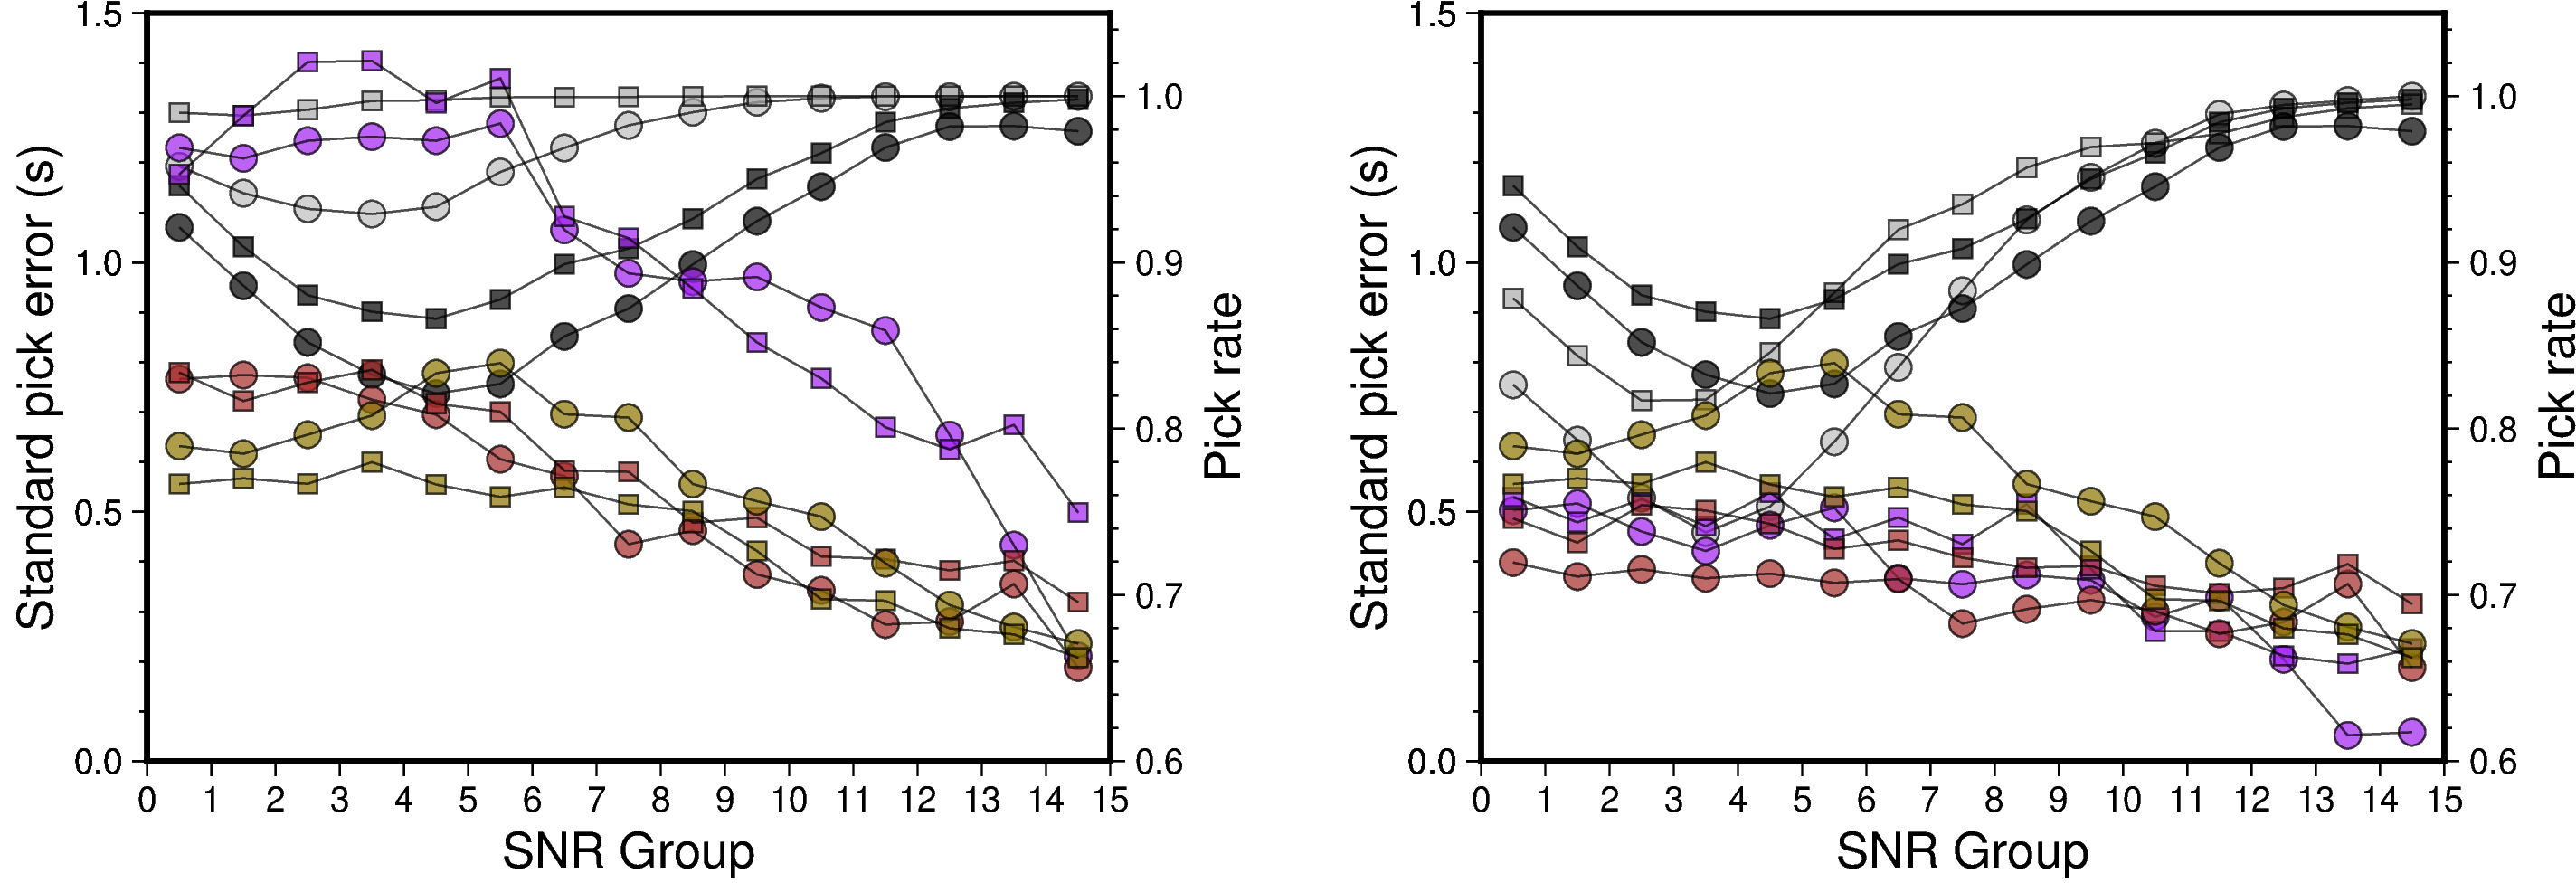

In [28]:
# plot picking rate instead of number of picks
fig = pygmt.Figure()
# Bottom row, two subplots
with fig.subplot(nrows=1, ncols=2, figsize=("21.5c", "7c"), autolabel=None, margins=["1.5c", "0c"]):
    # fig.legend(position="jBR+o0.2c", box=True)         
    # ======= Plot for ensemble-simple ========
    fig.basemap(
        region=region4d, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 0]
    )
    with fig.set_panel(panel=[0, 0]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3d,frame=['E', 'yaf+l"Pick rate"'])  
        # plot for ppicks detections
        SFB_p_stats_list = []
        for ifolder in range(nsnrs): 
            SFB_nppicks = int(p_pick_stats_list4[ifolder,0])/ntrace_list[ifolder]
            SFB_p_stats_list.append(SFB_nppicks)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill[0],
            error_bar = False,
            transparency = transparency,
            # label = 'P-pick rate (ensemble)'
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )
        # plot for spicks detections
        SFB_s_stats_list = []
        for ifolder in range(nsnrs): 
            SFB_nspicks = int(s_pick_stats_list4[ifolder,0])/ntrace_list[ifolder]
            SFB_s_stats_list.append(SFB_nspicks)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_stats_list
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill[1],
            error_bar = False,
            transparency = transparency,
            # label = 'S-pick rate (ensemble)'
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )
        
        # ======== plot for tranfer learning with different color
        # plot for ppicks detections
        SFB_p_stats_list3 = []
        for ifolder in range(nsnrs): 
            SFB_nppicks3 = int(p_pick_stats_list5[ifolder,0])/ntrace_list[ifolder]
            SFB_p_stats_list3.append(SFB_nppicks3)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_stats_list3
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        ) 
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill[3],
            error_bar = False,
            transparency = transparency,
            # label = 'P-pick rate (tf)'
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )  
        
        # plot for spicks detections
        SFB_s_stats_list3 = []
        for ifolder in range(nsnrs): 
            SFB_nspicks3 = int(s_pick_stats_list5[ifolder,0])/ntrace_list[ifolder]
            SFB_s_stats_list3.append(SFB_nspicks3)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_stats_list3
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        )   
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill[3],
            error_bar = False,
            transparency = transparency,
            # label = 'S-pick rate (tf)'
        )   
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )
        
        # fig.legend(position="J1c/8c+w5/3+jBL+o0.2c", box=True)  
        
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
           fig.basemap(region=region4p, frame=["W", 'ya0.5f0.1+l"Standard pick error (s)"']) 
           
        # ========= ensemble maximum
        # plot ppick mean and std    
        SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
        # plot spick mean and std    
        SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
        # ========= ensemble maximum + learning
        # plot ppick mean and std    
        SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list4) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        # plot spick mean and std    
        SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list4) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_pick_stats_list[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
    
        # ======== plot for transfer learning with different colors
        # plot ppick mean and std    
        SFB_p_pick_stats_list5 = np.squeeze(p_pick_stats_list5) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_pick_stats_list5[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[5],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        ) 
        
        # plot spick mean and std    
        SFB_s_pick_stats_list5 = np.squeeze(s_pick_stats_list5) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_pick_stats_list5[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[5],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
    # ======= Plot for ensemble-semblance ========
    fig.basemap(
        region=region4p, projection="X?", frame=['xa1f1+l"SNR Group"'], panel=[0, 1]
    )
    with fig.set_panel(panel=[0, 1]):
        # Plot the Y axis for y1 data
        # The left axis (W) is plotted with blue annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
            fig.basemap(region=region3d,frame=['E', 'yaf+l"Pick rate"'])   
            
        # plot for ppicks detections
        SFB_p_stats_list2 = []
        for ifolder in range(nsnrs): 
            SFB_nppicks2 = int(p_pick_stats_list4[ifolder,3])/ntrace_list[ifolder]
            SFB_p_stats_list2.append(SFB_nppicks2)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_stats_list2
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill[0],
            error_bar = False,
            transparency = transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )    
        
        # plot for spicks detections
        SFB_s_stats_list2 = []
        for ifolder in range(nsnrs): 
            SFB_nspicks2 = int(s_pick_stats_list4[ifolder,3])/ntrace_list[ifolder]
            SFB_s_stats_list2.append(SFB_nspicks2)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_stats_list2
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        )  
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill[1],
            error_bar = False,
            transparency = transparency,
        )   
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        ) 
        
        # ======== plot for transfer learning with different color
        # plot for ppicks detections
        SFB_p_stats_list3 = []
        for ifolder in range(nsnrs): 
            SFB_nppicks3 = int(p_pick_stats_list5[ifolder,0])/ntrace_list[ifolder]
            SFB_p_stats_list3.append(SFB_nppicks3)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_stats_list3
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        ) 
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill[3],
            error_bar = False,
            transparency = transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )  
        
        # plot for spicks detections
        SFB_s_stats_list3 = []
        for ifolder in range(nsnrs): 
            SFB_nspicks3 = int(s_pick_stats_list5[ifolder,0])/ntrace_list[ifolder]
            SFB_s_stats_list3.append(SFB_nspicks3)
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_stats_list3
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": np.zeros([nsnrs,]),
            "y-error": np.zeros([nsnrs,]),
        }
        )   
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill[3],
            error_bar = False,
            transparency = transparency,
        )   
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency = transparency
        )
        
        # Plot the Y axis for y2 data
        # The right axis (E) is plotted with red annotations, ticks, and label
        with pygmt.config(
            MAP_FRAME_PEN="black",
            MAP_TICK_PEN="black",
            FONT_ANNOT_PRIMARY="black",
            FONT_LABEL="black",
        ):
           fig.basemap(region=region4s, frame=["W", 'ya0.5f0.1+l"Standard pick error (s)"']) 
        
        # ======== ensemble semblance
        # plot ppick mean and std    
        SFB_p_pick_stats_list2 = np.squeeze(p_pick_stats_list2) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_pick_stats_list2[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
        # plot spick mean and std    
        SFB_s_pick_stats_list2 = np.squeeze(s_pick_stats_list2) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_pick_stats_list2[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[3],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
           
        # ======== ensemble semblance + learning
        # plot ppick mean and std    
        SFB_p_pick_stats_list = np.squeeze(p_pick_stats_list4) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_pick_stats_list[:,5]
        x_err, y_err = np.zeros([nsnrs,]),np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        # plot spick mean and std    
        SFB_s_pick_stats_list = np.squeeze(s_pick_stats_list4) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_pick_stats_list[:,5]
        x_err, y_err = np.zeros([nsnrs,]),np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[4],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
        # ======== plot for transfer learning with different colors
        # plot ppick mean and std    
        SFB_p_pick_stats_list5 = np.squeeze(p_pick_stats_list5) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_p_pick_stats_list5[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="c0.25c",
            pen="0.5p,black",
            color=cfill3[5],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        ) 
        
        # plot spick mean and std    
        SFB_s_pick_stats_list5 = np.squeeze(s_pick_stats_list5) 
        x, y = np.arange(0.5, nsnrs+0.5), SFB_s_pick_stats_list5[:,2]
        x_err, y_err = np.zeros([nsnrs,]), np.zeros([nsnrs,])
        df = pd.DataFrame(
        data={
            "x": x,
            "y": y,
            "x-error": x_err,
            "y-error": y_err,
        }
        )
        # plot markers
        fig.plot(
            data=df.to_numpy(),
            style="s0.25c",
            pen="0.5p,black",
            color=cfill3[5],
            error_bar = False,
            transparency=transparency
        )
        # plot line
        fig.plot(
            x=x,
            y=y,
            pen="0.5p,black",
            transparency=transparency
        )
        
fig.show()